In [1]:
import json, pathlib, random, time
from collections import defaultdict
import numpy as np
import pandas as pd
import multiprocessing as mp

from environment import Env, validate_against_hint, load_word_lists, construct_word_df


In [2]:
df = construct_word_df(*load_word_lists())

In [3]:


def construct_state_tensor(guesses, history):
        #print(history)
        #so the state is going to be:
            #  The number of green locations we know
            #  The number of other letters we know to be in the word
            #  The sequence number of the guess (1st guess, 2nd guess etc.)

        #the number of locations which were green at some point in the history
        num_green_locs = np.count_nonzero(history.max(axis=0) == 2)

        green_chars = [guesses[x][y] for x,y in np.argwhere(history == 2) ]
        orange_chars = [guesses[x][y] for x,y in np.argwhere(history == 1) ]
        black_chars = [guesses[x][y] for x,y in np.argwhere(history == 0) ]
        num_other_letters = len(set(orange_chars) - set(green_chars))
        num_black_letters = len(set(black_chars))

        sequence_number = int(history.size / 5)
        #print(f'construct_state() with seqno {sequence_number}')

        sequence_number_onehot = np.zeros(Env.num_guesses)
        sequence_number_onehot[sequence_number] = 1.0
        arr = np.concatenate((np.array([num_green_locs, num_other_letters, num_black_letters])/5, sequence_number_onehot))
        return torch.tensor(arr, device=device, dtype=torch.float)
        

    

The aim here is to use a NN to represent the policy, rather than the value function.  We will shrink the action space (ie, so that we have a few actions, rather than 12000).  This will remove the model's ability to learn novel strategies, rather it will just be learning when to employ the different strategies (actions) that I give it.  Start w
ith these 3 word selection tactics:

1. choose words which match the current history
1. choose words which contain the greatest number of new letters
1. choose words which have the highest frequency score

then we will construct 6 actions by choosing every possible order of these strategies
1. 1,2,3
1. 1,3,2
1. 2,1,3
1. 2,3,1
1. 3,1,2
1. 3,2,1

for all these actions there may be multiple words, so sample a random one.  The policy then becomes a logistic regressor which selects one of these actions to execute.  The loss to train the regressor will be derived using the policy gradiet theorem.


In [4]:
#https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count, permutations

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Categorical


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

#plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def clear(self):
        self.memory.clear()
        
    def __len__(self):
        return len(self.memory)
    

In [6]:
class PolicyNetNN(nn.Module):

    def __init__(self, num_inputs, num_actions):
        super(PolicyNetNN, self).__init__()
        self.fc1 = nn.Linear(num_inputs, 20)
        self.head = nn.Linear(20, num_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.fc1(x))
        return F.softmax(self.head(x), dim=0)

In [7]:
class PolicyNetLinear(nn.Module):

    def __init__(self, num_inputs, num_actions):
        super(PolicyNetLinear, self).__init__()
        self.head = nn.Linear(num_inputs, num_actions)
        #print(f'PolicyNetLinear {num_inputs}, {num_actions}')

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        return F.softmax(self.head(x), dim=0)
    
class PolicyHybrid(nn.Module):
    def __init__(self, num_guesses, num_inputs, num_actions):
        super(self.__class__, self).__init__()
        self.functions = torch.nn.ModuleList()
        self.function0 = torch.nn.Parameter(torch.ones((num_actions), dtype=float), requires_grad=True)
        for i in range(1, num_guesses):
            self.functions.append(nn.Linear(num_inputs - num_guesses, num_actions))
        self.x = torch.Tensor([1.0,1.0])

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, state):
        onehot = state[3:]
        step_idx = torch.argmax(onehot, dim=0)
        if step_idx == 0:
            y = self.x.mul(self.function0)
        else:
            x = state[0:3].to(device)
            y = self.functions[step_idx-1](x)
        return F.softmax(y, dim=0)
    
class PolicyMonteCarlo(nn.Module):
    def __init__(self, num_guesses, num_actions):
        super(PolicyMonteCarlo, self).__init__()
        #self.weights = torch.nn.Parameter(torch.rand((num_guesses, num_actions), dtype=float), requires_grad=True)
        self.weights = torch.nn.Parameter(torch.ones((num_guesses, num_actions), dtype=float), requires_grad=True)
        #self.weights.require_grad = True
        self.x = torch.Tensor([1.0,1.0])
        
    def forward(self, state):
        onehot = state[3:]
        step_idx = torch.argmax(onehot, dim=0)
        
        y = F.softmax(self.x.mul(self.weights[step_idx]), dim=0)
        #print(f'onehot {onehot}, step_idx {step_idx}')
        #print(self.weights)
        #print(self.weights[step_idx])
        #print(y)
        return y
    
class PolicyAvgReward():
    def __init__(self, num_guesses, num_actions):
        #self.weights = torch.Tensor([[.5,.5],[1,0],[1,0],[1,0],[1,0],[1,0]])
        self.weights = torch.rand((num_guesses, num_actions), dtype=float)
        
        self.reward_stats = [(defaultdict(int),defaultdict(int)) for _ in range(num_guesses)]
        self.num_guesses = num_guesses
        self.num_actions = num_actions
        
    def __call__(self, state):
        onehot = state[3:]
        step_idx = torch.argmax(onehot, dim=0)
        #if step_idx == 0:
        return F.softmax(self.weights[step_idx], dim=0)
        #else:
        #    return self.weights[step_idx]
    
    def calc_avgs(self):
        for action in range(self.num_actions):
            for step_idx in range(self.num_guesses):
                if self.reward_stats[step_idx][action]['count'] > 0:
                    self.weights[step_idx][action] = self.reward_stats[step_idx][action]['total'] / self.reward_stats[step_idx][action]['count']
        

In [8]:
#define the word-selection tactics
n_state_features = 9

class PolicyHelper:
    def __init__(self, env):
        self.env = env
        self.actions = [[env.find_target_words, env.find_words_matching_current_history]]
        self.actions.append([env.find_words_with_highest_new_letter_freq_score])
                
        self.num_actions = len(self.actions)
        #self.net = PolicyNetLinear(n_state_features, len(self.actions))
        
    def perform_action(self, action_idx):
        tactic_tuple = self.actions[action_idx]
        df = self.env.df
        for tactic in tactic_tuple: # apply all the tactics in the given order
            newdf = tactic(df)
            if not newdf.empty: #if that tactic produced no results, then quit
                df = newdf
        return df.sample()['word'][0] # then pick a random word from what is left
    
    

In [9]:





def plot_values(vals, axes=['duration', 'episode']):
    plt.figure(2)
    plt.clf()
    plt.title('Training...')
    plt.xlabel(axes[1])
    plt.ylabel(axes[0])
    plt.plot(np.array(vals))
    # Take 20 episode averages and plot them too
    window_width = 20
    if len(vals) >= window_width:
        cumsum_vec = np.cumsum(np.insert(vals, 0, 0)) 
        ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
        plt.plot(np.insert(ma_vec, 0, [None]*int(window_width/2)))

    plt.pause(0.001)  # pause a bit so that plots are updated
    #if is_ipython:
    #    display.clear_output(wait=True)
    #    display.display(plt.gcf())
    
def plot_all(episode_durations, episode_rewards, losses, epsilons, gammas):
    plot_values(episode_durations, axes=['duration', 'episode'])
    plot_values(episode_rewards, axes=['reward', 'episode'])
    if losses: plot_values(losses, axes=['loss', 'step'])
    if epsilons: plot_values(epsilons, axes=['epsilon', 'step'])
    if gammas: plot_values(gammas, axes=['gamma', 'step'])
    #plt.ioff()
    plt.show()

In [10]:
def optimize_model_batch(model, optimizer, memory, batch_size=128):
    if batch_size <= 0:
        transitions = memory.memory
    else:
        transitions = memory.sample(batch_size)
    print(f'optimize_model_batch {batch_size} {len(transitions)}')
    losses = [optimize_model_single(model, optimizer, tr.state, tr.action, tr.reward) for tr in transitions]
    
    return losses

optimizations_run = 0

def optimize_model_single(model, optimizer, state, action, reward):
    global optimizations_run
    optimizations_run += 1
    if isinstance(model, PolicyAvgReward):
        onehot = state[3:]
        step_idx = torch.argmax(onehot, dim=0)
        model.reward_stats[step_idx][action]['count'] += 1
        model.reward_stats[step_idx][action]['total'] += reward
        model.calc_avgs()
        return reward
    # calculate gradient
    probs = model(state)
    sampler = Categorical(probs)
    #print(f'sampler {sampler}')
    log_probs = -sampler.log_prob(action)   # "-" because it was built to work with gradient descent, but we are using gradient ascent

    pseudo_loss = log_probs * reward # loss that when differentiated with autograd gives the gradient of J(θ)
    #print(f'log_prob {log_probs}, reward {reward}, loss {pseudo_loss} ')
    # update policy weights
    optimizer.zero_grad()
    pseudo_loss.backward()
    optimizer.step()

    return pseudo_loss


class TrainConfig():
    def __init__(self, optimizer='adam', batch_size=64, train_interval=64, clear_memory=False, lr=0.01):
        self.optimizer = optimizer
        self.clear_memory = clear_memory
        self.lr = lr
        self.train_interval = train_interval
        self.batch_size = batch_size
        
class ValueConfig():
    def __init__(self, name='reward', gamma=[0.9, 0.05, 200]):
        self.name = name
        self.gamma = gamma
        
class ModelConfig():
    def __init__(self, name='naive', startword=None, target_list_only=None):
        self.name = name
        self.startword = startword
        self.target_list_only = target_list_only

In [11]:
#https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
def run_experiment(model=ModelConfig(name='naive', startword=None, target_list_only=False),
                   num_episodes=128,
                   eps=[0.9, 0.05, 200],
                   value_function=ValueConfig(name='reward',gamma=[0.0, 1.0, 200]),
                   training=TrainConfig(),
                   seed=0,
                   run_test=False):
    global optimizations_run
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    GAMMA_START, GAMMA_END, GAMMA_DECAY = value_function.gamma
    env = Env(df)
    memory = ReplayMemory(10000)
    starting_state = construct_state_tensor(env.guesses, env.history)

    steps_done = 0
    last_training = 0
    losses = []
    episode_rewards = []
    episode_durations = []
    epsilons = []
    gammas = []
    reward_stats = [(defaultdict(int),defaultdict(int)) for _ in range(env.num_guesses)]
    transitions_added_to_memory = 0
    optimizations_run = 0
    
    policy_helper = PolicyHelper(env)
    
    if model.name == 'linear':
        policy_net = PolicyNetLinear(n_state_features, len(policy_helper.actions)).to(device)
    elif model.name == 'monte':
        policy_net = PolicyMonteCarlo(env.num_guesses, len(policy_helper.actions)).to(device)
        print('monte weights')
        print(policy_net.weights)
        print(F.softmax(policy_net.weights, dim=1))
    elif model.name == 'avg_reward':
        policy_net = PolicyAvgReward(env.num_guesses, len(policy_helper.actions))
    elif model.name == 'hybrid':
        policy_net = PolicyHybrid(env.num_guesses, n_state_features, len(policy_helper.actions))
    else:
        policy_net = PolicyNetNN(n_state_features, len(policy_helper.actions)).to(device)
    
    if model.name == 'avg_reward':
        optimizer = None
    elif training.optimizer == 'rmsprop':
        optimizer = optim.RMSprop(policy_net.parameters(), lr=training.lr)
    elif training.optimizer == 'sgd':
        optimizer = optim.SGD(policy_net.parameters(), lr=training.lr)
    else:
        optimizer = optim.Adam(policy_net.parameters(), lr=training.lr)

        #print(f'pn params {list(policy_net.parameters())}')
    for i_episode in range(num_episodes):
        # Initialize the environment and state
        env.reset()
        print(f'=========================episode {i_episode} {env.target}======================')

        episode_memory = []
        state = starting_state
        guesses = []
        for t in count():
            GAMMA = GAMMA_END + (GAMMA_START - GAMMA_END) * math.exp(-1. * steps_done / GAMMA_DECAY)
            gammas.append(GAMMA)
            steps_done += 1
            # Select and perform an action
            #print(state, actions)
            probs = policy_net(state)
            sampler = Categorical(probs)
            action_idx = sampler.sample()
            chosen_word = policy_helper.perform_action(action_idx)
            guesses.append(chosen_word)
            print(f'------guess {t} {action_idx} {guesses[-1]}-------')
            history, reward, done = env.step(chosen_word)
            #here next_state == env.history
            if not done:
                next_state = construct_state_tensor(guesses, history)
            
            #action_tensor = action_idx.clone().detach()
            action = action_idx #F.one_hot(action_idx, num_classes=policy_helper.num_actions)
                
            print(f'reward {reward} done {done} action {action}')
            #reward = np.array([reward])

            # Store the transition in memory
            #memory.push(state, action_idx, reward)
            episode_memory.append([state, action, reward])
            # Move to the next state
            state = next_state

            if done:
                episode_durations.append(t + 1)
                episode_reward = sum([tr[2] for tr in episode_memory])
                print(f'episode {i_episode} finished.  reward {episode_reward}  eps {eps}  gamma {GAMMA}  steps {steps_done}  memory {len(memory)}')
                episode_rewards.append(episode_reward)
                
                for idx,tr in enumerate(episode_memory):
                    #print(f'pushing episode_reward {episode_reward} {episode_reward.__class__}')
                    transitions_added_to_memory += 1
                    memory.push(tr[0], tr[1], episode_reward)
                    #loss = optimize_model_single(policy_net, optimizer, tr[0], tr[1], episode_reward)
                    #losses.append(loss)
                
                    reward_stats[idx][tr[1]]['count'] += 1
                    reward_stats[idx][tr[1]]['total'] += episode_reward
                    episode_reward -= tr[2]
                    
                    
                # If we have gathered enough data, Perform one step of the optimization (on the policy network)
                if len(memory) >= max(1,training.batch_size) \
                    and (i_episode + 1) % training.train_interval == 0:
                    losses += optimize_model_batch(policy_net, optimizer, memory, batch_size=training.batch_size)
                    if training.clear_memory: memory.clear()
                        
                    if model.name == 'monte':
                        print('monte weights')
                        print(policy_net.weights)
                        print(F.softmax(policy_net.weights, dim=1))
                        for rs in reward_stats:
                            if rs[0]['count'] > 0:
                                rs[0]['avg'] = rs[0]['total'] / rs[0]['count']
                            if rs[1]['count'] > 0:
                                rs[1]['avg'] = rs[1]['total'] / rs[1]['count']
                            print(dict(rs[0]), dict(rs[1]))
                    elif model.name == 'avg_reward':
                        print('avg_reward weights')
                        print(policy_net.weights)
                        print(F.softmax(policy_net.weights, dim=1))
                        for rs in policy_net.reward_stats:
                            if rs[0]['count'] > 0:
                                rs[0]['avg'] = rs[0]['total'] / rs[0]['count']
                            if rs[1]['count'] > 0:
                                rs[1]['avg'] = rs[1]['total'] / rs[1]['count']
                            print(dict(rs[0]), dict(rs[1]))
                    elif model.name == 'hybrid':
                        print('hybrid weights')
                        print(policy_net.function0)
                        print(F.softmax(policy_net.function0, dim=0))
                    print(f'done {optimizations_run} optimizations, {transitions_added_to_memory} transitions added to memory')
                    
                        
                        
                
                #plot_durations()
                break

    print('Training Complete')
    
    if run_test:
        performance_hist = [0] * (1 + env.num_guesses)
        for e in env.foreach_target_word():
            state = starting_state
            done = False
            reward = 0
            num_guesses = 0
            while not done:
                probs = policy_net(state)
                sampler = Categorical(probs)
                action_idx = sampler.sample()
                chosen_word = policy_helper.perform_action(action_idx)
                _, reward, done = e.step(chosen_word)
                num_guesses += 1
            
            if num_guesses == 6 and reward == -1:
                num_guesses = 0
            print(f'{e.target} {num_guesses}')    
            performance_hist[num_guesses] += 1
            
        for i,p in enumerate(performance_hist):
            print(f'{i}: {p}')
    
    return episode_durations, episode_rewards, losses, epsilons, gammas

#env.render()
#env.close()
#plt.ioff()
#plt.show()

=========================episode 0 nanny======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 mammy-------
reward -1 done False action 0
------guess 2 0 gassy-------
reward -1 done False action 0
------guess 3 0 happy-------
reward -1 done False action 0
------guess 4 1 unlid-------
reward -1 done False action 1
------guess 5 0 fancy-------
reward -1 done True action 0
episode 0 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.024690087971667385  steps 6  memory 0
=========================episode 1 catty======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 1 budge-------
reward -1 done False action 1
------guess 4 1 wakfs-------
reward -1 done False action 1
------guess 5 1 avyze-------
reward -1 done True action 1
episode 1 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.053514

------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 pouch-------
reward -1 done False action 0
------guess 3 0 cough-------
reward 0 done True action 0
episode 20 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.36237184837822667  steps 91  memory 87
=========================episode 21 float======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 0 aloft-------
reward -1 done False action 0
------guess 4 0 float-------
reward 0 done True action 0
episode 21 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.3781149435349799  steps 96  memory 91
=========================episode 22 glory======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump---

------guess 2 0 poser-------
reward -1 done False action 0
------guess 3 1 duchy-------
reward -1 done False action 1
------guess 4 0 sower-------
reward -1 done False action 0
------guess 5 1 bumfs-------
reward -1 done True action 1
episode 39 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.6074141344684816  steps 188  memory 182
=========================episode 40 sauna======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 paddy-------
reward -1 done False action 0
------guess 2 0 canal-------
reward -1 done False action 0
------guess 3 1 gibus-------
reward -1 done False action 1
------guess 4 1 fehme-------
reward -1 done False action 1
------guess 5 0 sauna-------
reward 0 done True action 0
episode 40 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.6190168002606627  steps 194  memory 188
=========================episode 41 hover======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 cove

------guess 4 1 gamba-------
reward -1 done False action 1
------guess 5 1 wakfs-------
reward -1 done True action 1
episode 58 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.7471604041952535  steps 276  memory 270
=========================episode 59 enjoy======================
------guess 0 0 ingot-------
reward -1 done False action 0
------guess 1 0 endow-------
reward -1 done False action 0
------guess 2 1 carls-------
reward -1 done False action 1
------guess 3 1 humpy-------
reward -1 done False action 1
------guess 4 0 envoy-------
reward -1 done False action 0
------guess 5 1 bumfs-------
reward -1 done True action 1
episode 59 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.7546329435470737  steps 282  memory 276
=========================episode 60 motif======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 0 vom

------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 edify-------
reward -1 done False action 0
------guess 2 0 geese-------
reward -1 done False action 0
------guess 3 0 spell-------
reward -1 done False action 0
------guess 4 0 swell-------
reward 0 done True action 0
episode 76 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.8419746791103522  steps 370  memory 365
=========================episode 77 gorge======================
------guess 0 0 murky-------
reward -1 done False action 0
------guess 1 1 toeas-------
reward -1 done False action 1
------guess 2 0 force-------
reward -1 done False action 0
------guess 3 1 pling-------
reward -1 done False action 1
------guess 4 0 gorge-------
reward 0 done True action 0
episode 77 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.8458763381848686  steps 375  memory 370
=========================episode 78 title======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin

------guess 4 0 comic-------
reward 0 done True action 0
episode 95 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.8972030915647136  steps 456  memory 451
=========================episode 96 stiff======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 stuck-------
reward -1 done False action 0
------guess 2 0 sting-------
reward -1 done False action 0
------guess 3 1 lymph-------
reward -1 done False action 1
------guess 4 1 bifid-------
reward -1 done False action 1
------guess 5 0 stiff-------
reward 0 done True action 0
episode 96 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9002411993463814  steps 462  memory 456
=========================episode 97 focal======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 allow-------
reward -1 done False action 0
------guess 2 0 zonal-------
reward -1 done False action 0
------guess 3 1 scudi-------
reward -1 done False action 1
------guess 4 1 nymph

------guess 3 0 wafer-------
reward -1 done False action 0
------guess 4 0 caper-------
reward -1 done False action 0
------guess 5 0 gazer-------
reward -1 done True action 0
episode 115 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.9347807103318725  steps 547  memory 541
=========================episode 116 cloud======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 mogul-------
reward -1 done False action 0
------guess 3 1 chawk-------
reward -1 done False action 1
------guess 4 1 biped-------
reward -1 done False action 1
------guess 5 0 cloud-------
reward 0 done True action 0
episode 116 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9367082316403592  steps 553  memory 547
=========================episode 117 favor======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 moral-------
reward -1 done False action 0
------guess 2 0 

------guess 3 1 nymph-------
reward -1 done False action 1
------guess 4 1 fudge-------
reward -1 done False action 1
------guess 5 0 quilt-------
reward 0 done True action 0
episode 130 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9558428315803071  steps 625  memory 8
=========================episode 131 rabbi======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 fairy-------
reward -1 done False action 0
------guess 2 0 radii-------
reward -1 done False action 0
------guess 3 0 rabbi-------
reward 0 done True action 0
episode 131 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9567172020980341  steps 629  memory 14
=========================episode 132 teddy======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 fetus-------
reward -1 done False action 0
------guess 2 1 linch-------
reward -1 done False action 1
------guess 3 1 dampy-------
reward -1 done False action 1
------guess 4 0 tedd

------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 first-------
reward -1 done False action 0
------guess 2 0 crust-------
reward -1 done False action 0
------guess 3 0 trust-------
reward 0 done True action 0
episode 150 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9714186250837188  steps 712  memory 97
=========================episode 151 hilly======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 duchy-------
reward -1 done False action 0
------guess 2 0 hippy-------
reward -1 done False action 0
------guess 3 1 limns-------
reward -1 done False action 1
------guess 4 0 hilly-------
reward 0 done True action 0
episode 151 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.972124301744753  steps 717  memory 101
=========================episode 152 treat======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 gre

------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 gusty-------
reward -1 done False action 0
------guess 2 1 linch-------
reward -1 done False action 1
------guess 3 0 witty-------
reward -1 done False action 0
------guess 4 0 ditty-------
reward -1 done False action 0
------guess 5 0 bitty-------
reward -1 done True action 0
episode 170 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.9815002858801808  steps 799  memory 182
=========================episode 171 metal======================
------guess 0 0 think-------
reward -1 done False action 0
------guess 1 0 etude-------
reward -1 done False action 0
------guess 2 0 facet-------
reward -1 done False action 0
------guess 3 1 slorm-------
reward -1 done False action 1
------guess 4 1 pygmy-------
reward -1 done False action 1
------guess 5 0 metal-------
reward 0 done True action 0
episode 171 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9820470350604972  steps 805  memory 188
======================

------guess 1 1 islet-------
reward -1 done False action 1
------guess 2 0 juicy-------
reward -1 done False action 0
------guess 3 1 whomp-------
reward -1 done False action 1
------guess 4 0 dizzy-------
reward 0 done True action 0
episode 188 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9880257886991963  steps 886  memory 270
=========================episode 189 magma======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 1 budge-------
reward -1 done False action 1
------guess 4 0 magma-------
reward 0 done True action 0
episode 189 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9883214330296045  steps 891  memory 275
=========================episode 190 miner======================
------guess 0 0 cramp-------
reward -1 done False action 0
------guess 1 1 teloi-------
reward -1 done False action 1
------guess 2 1 d

------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 junto-------
reward -1 done False action 0
------guess 2 0 quoth-------
reward 0 done True action 0
episode 208 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9920929459484066  steps 969  memory 355
=========================episode 209 nasal======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 laugh-------
reward -1 done False action 0
------guess 2 0 manly-------
reward -1 done False action 0
------guess 3 0 nasal-------
reward 0 done True action 0
episode 209 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9922495161088634  steps 973  memory 358
=========================episode 210 saint======================
------guess 0 0 prowl-------
reward -1 done False action 0
------guess 1 1 entia-------
reward -1 done False action 1
------guess 2 1 cushy-------
reward -1 done False action 1
------guess 3 0 saint-------
reward 0 done True action 0
episode 210 finishe

------guess 1 0 brawn-------
reward -1 done False action 0
------guess 2 0 grown-------
reward -1 done False action 0
------guess 3 0 frown-------
reward -1 done False action 0
------guess 4 0 crown-------
reward -1 done False action 0
------guess 5 0 drown-------
reward 0 done True action 0
episode 230 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9949329678118393  steps 1058  memory 441
=========================episode 231 occur======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 fjord-------
reward -1 done False action 0
------guess 2 0 curio-------
reward -1 done False action 0
------guess 3 0 occur-------
reward 0 done True action 0
episode 231 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9950333017715621  steps 1062  memory 447
=========================episode 232 friar======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1

------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 0 cheap-------
reward 0 done True action 0
episode 251 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9967202890976564  steps 1145  memory 530
=========================episode 252 ingot======================
------guess 0 0 ninja-------
reward -1 done False action 0
------guess 1 1 estro-------
reward -1 done False action 1
------guess 2 0 tonic-------
reward -1 done False action 0
------guess 3 1 duply-------
reward -1 done False action 1
------guess 4 0 ingot-------
reward 0 done True action 0
episode 252 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9968012654483569  steps 1150  memory 534
=========================episode 253 libel======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0

------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 groom-------
reward -1 done False action 0
------guess 2 1 lysin-------
reward -1 done False action 1
------guess 3 0 rowdy-------
reward 0 done True action 0
episode 268 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9977232356757451  steps 1218  memory 50
=========================episode 269 seedy======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 seedy-------
reward 0 done True action 0
episode 269 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9977571322805142  steps 1221  memory 54
=========================episode 270 paint======================
------guess 0 0 haven-------
reward -1 done False action 0
------guess 1 1 lirot-------
reward -1 done False action 1
------guess 2 0 paint-------
reward 0 done True action 0
episode 270 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.99779052423058

------guess 1 0 psalm-------
reward -1 done False action 0
------guess 2 0 khaki-------
reward -1 done False action 0
------guess 3 0 aback-------
reward 0 done True action 0
episode 289 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9984661893206755  steps 1297  memory 129
=========================episode 290 arise======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 barge-------
reward -1 done False action 0
------guess 2 1 lysin-------
reward -1 done False action 1
------guess 3 1 chump-------
reward -1 done False action 1
------guess 4 1 fiked-------
reward -1 done False action 1
------guess 5 0 arise-------
reward 0 done True action 0
episode 290 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9985115202769406  steps 1303  memory 133
=========================episode 291 cease======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 place-------
reward -1 done False action 0
------guess 2 0

------guess 2 1 lotsa-------
reward -1 done False action 1
------guess 3 0 resin-------
reward 0 done True action 0
episode 309 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9990022422035156  steps 1383  memory 215
=========================episode 310 whisk======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 ficus-------
reward -1 done False action 0
------guess 3 0 skimp-------
reward -1 done False action 0
------guess 4 0 whisk-------
reward 0 done True action 0
episode 310 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9990268769312853  steps 1388  memory 219
=========================episode 311 choke======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 vogue-------
reward -1 done False action 0
------guess 2 1 lysin-------
reward -1 done False action 1
------guess 3 0 choke-------
reward 0 done True action 0
episode 311 finis

=========================episode 329 chide======================
------guess 0 0 olive-------
reward -1 done False action 0
------guess 1 1 trans-------
reward -1 done False action 1
------guess 2 1 duchy-------
reward -1 done False action 1
------guess 3 1 gimpy-------
reward -1 done False action 1
------guess 4 1 bawks-------
reward -1 done False action 1
------guess 5 0 chide-------
reward 0 done True action 0
episode 329 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9993574076396444  steps 1471  memory 301
=========================episode 330 pooch======================
------guess 0 0 boxer-------
reward -1 done False action 0
------guess 1 0 mossy-------
reward -1 done False action 0
------guess 2 1 cital-------
reward -1 done False action 1
------guess 3 0 vouch-------
reward -1 done False action 0
------guess 4 0 pooch-------
reward 0 done True action 0
episode 330 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9993732733015516  steps 1476  memory 307
===============

------guess 1 0 voila-------
reward -1 done False action 0
------guess 2 0 modal-------
reward -1 done False action 0
------guess 3 0 loyal-------
reward -1 done False action 0
------guess 4 0 local-------
reward 0 done True action 0
episode 349 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.999577786733191  steps 1555  memory 386
=========================episode 350 teeth======================
------guess 0 0 spark-------
reward -1 done False action 0
------guess 1 0 excel-------
reward -1 done False action 0
------guess 2 0 needy-------
reward -1 done False action 0
------guess 3 0 teeth-------
reward 0 done True action 0
episode 350 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9995861471160212  steps 1559  memory 391
=========================episode 351 quota======================
------guess 0 0 wooer-------
reward -1 done False action 0
------guess 1 0 scout-------
reward -1 done False action 0
------guess 2 1 inlay-------
reward -1 done False action 1
------guess 3 0 

------guess 1 0 style-------
reward -1 done False action 0
------guess 2 0 bused-------
reward 0 done True action 0
episode 370 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9997225861157594  steps 1639  memory 472
=========================episode 371 lithe======================
------guess 0 0 gooey-------
reward -1 done False action 0
------guess 1 0 mecca-------
reward -1 done False action 0
------guess 2 1 tirls-------
reward -1 done False action 1
------guess 3 0 lithe-------
reward 0 done True action 0
episode 371 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9997280792787104  steps 1643  memory 475
=========================episode 372 bossy======================
------guess 0 0 visor-------
reward -1 done False action 0
------guess 1 0 lasso-------
reward -1 done False action 0
------guess 2 0 mossy-------
reward -1 done False action 0
------guess 3 1 centu-------
reward -1 done False action 1
------guess 4 0 bossy-------
reward 0 done True action 0
episode 372 finis

------guess 3 0 vigil-------
reward 0 done True action 0
episode 388 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.999806454900442  steps 1711  memory 15
=========================episode 389 gummy======================
------guess 0 0 visor-------
reward -1 done False action 0
------guess 1 1 laten-------
reward -1 done False action 1
------guess 2 0 mucky-------
reward -1 done False action 0
------guess 3 0 jumpy-------
reward -1 done False action 0
------guess 4 0 dummy-------
reward -1 done False action 0
------guess 5 1 baghs-------
reward -1 done True action 1
episode 389 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.9998121750225937  steps 1717  memory 19
=========================episode 390 overt======================
------guess 0 0 album-------
reward -1 done False action 0
------guess 1 1 torse-------
reward -1 done False action 1
------guess 2 1 pinch-------
reward -1 done False action 1
------guess 3 0 retro-------
reward -1 done False action 0
------guess 4 0 o

------guess 3 1 chump-------
reward -1 done False action 1
------guess 4 0 patio-------
reward 0 done True action 0
episode 408 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.999877205704879  steps 1802  memory 105
=========================episode 409 phone======================
------guess 0 0 slack-------
reward -1 done False action 0
------guess 1 0 rogue-------
reward -1 done False action 0
------guess 2 0 oxide-------
reward -1 done False action 0
------guess 3 0 phone-------
reward 0 done True action 0
episode 409 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9998796371948327  steps 1806  memory 110
=========================episode 410 cycle======================
------guess 0 0 steep-------
reward -1 done False action 0
------guess 1 1 loran-------
reward -1 done False action 1
------guess 2 0 cycle-------
reward 0 done True action 0
episode 410 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9998814291635456  steps 1809  memory 114
=========================episod

------guess 4 1 bawks-------
reward -1 done False action 1
------guess 5 0 mourn-------
reward 0 done True action 0
episode 427 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9999205195914495  steps 1889  memory 191
=========================episode 428 debar======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 smear-------
reward -1 done False action 0
------guess 2 0 cedar-------
reward -1 done False action 0
------guess 3 0 debar-------
reward 0 done True action 0
episode 428 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9999220934089849  steps 1893  memory 197
=========================episode 429 oxide======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 ozone-------
reward -1 done False action 0
------guess 2 1 sulci-------
reward -1 done False action 1
------guess 3 0 oxide-------
reward 0 done True action 0
episode 429 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.999923636062

------guess 3 0 salon-------
reward 0 done True action 0
episode 448 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9999472528069845  steps 1971  memory 275
=========================episode 449 women======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 woven-------
reward -1 done False action 0
------guess 3 0 women-------
reward 0 done True action 0
episode 449 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9999482972713856  steps 1975  memory 279
=========================episode 450 earth======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 earth-------
reward 0 done True action 0
episode 450 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9999490670247319  steps 1978  memory 283
=========================episode 451 ulcer======================
------guess 0 1 roate---

------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 hunky-------
reward -1 done False action 0
------guess 2 1 clips-------
reward -1 done False action 1
------guess 3 1 gamed-------
reward -1 done False action 1
------guess 4 0 civil-------
reward 0 done True action 0
episode 470 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9999667015597029  steps 2063  memory 366
=========================episode 471 chump======================
------guess 0 0 scary-------
reward -1 done False action 0
------guess 1 1 toile-------
reward -1 done False action 1
------guess 2 1 bundh-------
reward -1 done False action 1
------guess 3 1 grump-------
reward -1 done False action 1
------guess 4 0 chump-------
reward 0 done True action 0
episode 471 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9999675237011232  steps 2068  memory 371
=========================episode 472 abbot======================
------guess 0 0 delay-------
reward -1 done False action 0
------guess 1 0

------guess 2 1 cumin-------
reward -1 done False action 1
------guess 3 0 color-------
reward 0 done True action 0
episode 491 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9999779014817677  steps 2145  memory 449
=========================episode 492 tipsy======================
------guess 0 0 axial-------
reward -1 done False action 0
------guess 1 0 mince-------
reward -1 done False action 0
------guess 2 0 virus-------
reward -1 done False action 0
------guess 3 1 gothy-------
reward -1 done False action 1
------guess 4 0 tipsy-------
reward 0 done True action 0
episode 492 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9999784470961269  steps 2150  memory 453
=========================episode 493 totem======================
------guess 0 0 debut-------
reward -1 done False action 0
------guess 1 0 steal-------
reward -1 done False action 0
------guess 2 0 thief-------
reward -1 done False action 0
------guess 3 0 totem-------
reward 0 done True action 0
episode 493 finis

------guess 3 0 masse-------
reward 0 done True action 0
episode 511 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9999854802388728  steps 2229  memory 533
optimize_model_batch -1 537
avg_reward weights
tensor([[-3.4524, -3.4192],
        [-2.5413, -2.3407],
        [-1.2701, -1.7744],
        [-0.5059, -1.5714],
        [-0.2222, -1.4394],
        [-0.1509, -1.0000]], dtype=torch.float64)
tensor([[0.4917, 0.5083],
        [0.4500, 0.5500],
        [0.6235, 0.3765],
        [0.7437, 0.2563],
        [0.7716, 0.2284],
        [0.7004, 0.2996]], dtype=torch.float64)
{'count': 252, 'total': -870, 'avg': -3.4523809523809526} {'count': 260, 'total': -889, 'avg': -3.419230769230769}
{'count': 242, 'total': -615, 'avg': -2.541322314049587} {'count': 270, 'total': -632, 'avg': -2.3407407407407406}
{'count': 311, 'total': -395, 'avg': -1.270096463022508} {'count': 195, 'total': -346, 'avg': -1.7743589743589743}
{'count': 253, 'total': -128, 'avg': -0.5059288537549407} {'count': 140, 'tota

begun 3
azure 3
weave 5
genie 3
sound 4
glove 6
braid 3
scope 0
wryly 3
rover 0
assay 5
ocean 3
bloom 5
irate 0
later 3
woken 6
silky 5
wreck 5
dwelt 5
slate 5
smack 4
solid 3
amaze 3
hazel 3
wrist 5
jolly 4
globe 5
flint 3
rouse 5
civil 6
vista 4
relax 6
cover 0
alive 5
beech 5
jetty 5
bliss 5
vocal 3
often 4
dolly 6
eight 5
joker 0
since 4
event 0
ensue 3
shunt 3
diver 0
poser 0
worst 5
sweep 6
alley 2
creed 5
anime 4
leafy 5
bosom 3
dunce 4
stare 6
pudgy 5
waive 0
choir 4
stood 5
spoke 3
outgo 4
delay 3
bilge 4
ideal 3
clasp 0
seize 5
hotly 3
laugh 5
sieve 4
block 5
meant 0
grape 4
noose 3
hardy 5
shied 5
drawl 4
daisy 5
putty 2
strut 6
burnt 4
tulip 5
crick 5
idyll 0
vixen 6
furor 4
geeky 6
cough 5
naive 5
shoal 3
stork 3
bathe 3
aunty 5
check 3
prime 6
brass 0
outer 2
furry 0
razor 5
elect 4
evict 0
imply 4
demur 6
quota 0
haven 3
cavil 3
swear 3
crump 4
dough 5
gavel 4
wagon 6
salon 4
nudge 0
harem 5
pitch 5
sworn 3
pupil 6
excel 4
stony 3
cabin 6
unzip 5
queen 5
trout 0
polyp 5


scowl 0
frail 4
drift 0
limbo 4
fence 5
motel 5
ounce 6
wreak 0
revel 5
talon 4
prior 4
knelt 4
cello 5
flake 5
debug 4
anode 3
crime 0
salve 4
scout 4
imbue 5
pinky 0
stave 0
vague 4
chock 4
fight 0
video 6
stone 4
teach 0
cleft 4
frost 5
prawn 3
booty 4
twist 6
apnea 6
stiff 4
plaza 5
ledge 5
tweak 6
board 5
grant 5
medic 5
bacon 6
cable 4
brawl 5
slunk 6
raspy 3
forum 5
drone 0
women 5
mucus 5
boast 0
toddy 5
coven 4
tumor 5
truer 3
wrath 2
stall 6
steam 0
axial 4
purer 4
daily 5
trail 3
niche 5
mealy 6
juice 4
nylon 3
plump 0
merry 6
flail 5
papal 6
wheat 4
berry 4
cower 5
erect 5
brute 4
leggy 4
snipe 0
sinew 5
skier 4
penny 6
jumpy 0
rally 4
umbra 0
scary 4
modem 4
gross 6
avian 6
greed 5
satin 4
tonic 3
parka 5
sniff 4
livid 3
stark 4
trump 4
giddy 3
reuse 3
taboo 6
avoid 4
quote 4
devil 6
liken 3
gloss 0
gayer 5
beret 3
noise 6
gland 4
dealt 0
sling 5
rumor 4
opera 4
thigh 6
tonga 4
flare 6
wound 0
white 4
bulky 0
etude 4
horse 6
circa 4
paddy 0
inbox 4
fizzy 4
grain 0
exert 4


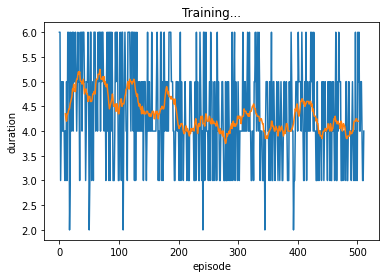

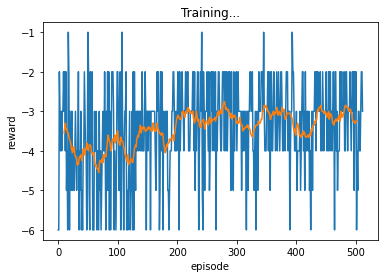

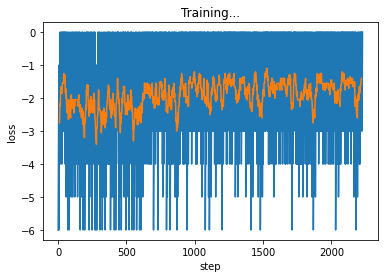

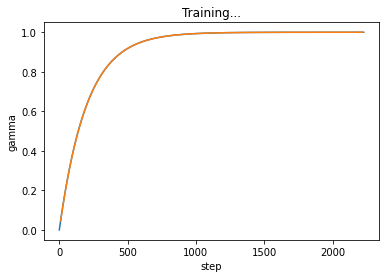

In [12]:
plot_all(*run_experiment(
    model=ModelConfig(name='avg_reward'),
    num_episodes=512,
    training=TrainConfig(optimizer='sgd', lr=0.01, batch_size=-1, train_interval=128, clear_memory=True),
    seed=1,
    run_test=True
    ))

monte weights
Parameter containing:
tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]], dtype=torch.float64, requires_grad=True)
tensor([[0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000]], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
=========================episode 0 nanny======================
------guess 0 0 spied-------
reward -1 done False action 0
------guess 1 0 balmy-------
reward -1 done False action 0
------guess 2 0 fatty-------
reward -1 done False action 0
------guess 3 0 canny-------
reward -1 done False action 0
------guess 4 1 rough-------
reward -1 done False action 1
------guess 5 0 nanny-------
reward 0 done True action 0
episode 0 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.024690087971667385  steps 6  memory 0
=========================episode 1 fetus======================
------guess 0 0 plaza-------
re

------guess 2 1 gundy-------
reward -1 done False action 1
------guess 3 1 abohm-------
reward -1 done False action 1
------guess 4 1 wakfs-------
reward -1 done False action 1
------guess 5 1 vozhd-------
reward -1 done True action 1
episode 18 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.3494909052766835  steps 87  memory 81
=========================episode 19 empty======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 petty-------
reward -1 done False action 0
------guess 3 1 duchy-------
reward -1 done False action 1
------guess 4 1 gamba-------
reward -1 done False action 1
------guess 5 0 empty-------
reward 0 done True action 0
episode 19 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.36871635449307405  steps 93  memory 87
=========================episode 20 swarm======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin--

------guess 2 0 alert-------
reward 0 done True action 0
episode 37 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.5768379176822511  steps 173  memory 170
=========================episode 38 bunch======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 kinky-------
reward -1 done False action 0
------guess 2 0 punch-------
reward -1 done False action 0
------guess 3 1 milds-------
reward -1 done False action 1
------guess 4 1 befog-------
reward -1 done False action 1
------guess 5 1 wavey-------
reward -1 done True action 1
episode 38 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.5893442472476544  steps 179  memory 173
=========================episode 39 pubic======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 civic-------
reward -1 done False action 0
------guess 3 1 bumph-------
reward -1 done False action 1
------guess 4 0 pubi

------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 weird-------
reward -1 done False action 0
------guess 2 1 shuln-------
reward -1 done False action 1
------guess 3 0 dried-------
reward -1 done False action 0
------guess 4 1 campy-------
reward -1 done False action 1
------guess 5 1 befog-------
reward -1 done True action 1
episode 57 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.735522738700176  steps 267  memory 261
=========================episode 58 using======================
------guess 0 0 bigot-------
reward -1 done False action 0
------guess 1 1 rales-------
reward -1 done False action 1
------guess 2 0 suing-------
reward -1 done False action 0
------guess 3 0 using-------
reward 0 done True action 0
episode 58 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.7407597393541085  steps 271  memory 267
=========================episode 59 duchy======================
------guess 0 0 datum-------
reward -1 done False action 0
------guess 1 1 oiler

------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 cluck-------
reward -1 done False action 0
------guess 3 1 bumph-------
reward -1 done False action 1
------guess 4 0 fluff-------
reward 0 done True action 0
episode 75 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.8305165505005299  steps 356  memory 351
=========================episode 76 macro======================
------guess 0 0 apple-------
reward -1 done False action 0
------guess 1 1 rotis-------
reward -1 done False action 1
------guess 2 0 croak-------
reward -1 done False action 0
------guess 3 0 macro-------
reward 0 done True action 0
episode 76 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.833872547653167  steps 360  memory 356
=========================episode 77 relay======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 0 relay-

------guess 1 0 spike-------
reward -1 done False action 0
------guess 2 0 nudge-------
reward -1 done False action 0
------guess 3 0 venue-------
reward -1 done False action 0
------guess 4 0 uncle-------
reward 0 done True action 0
episode 95 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.891390891175042  steps 445  memory 440
=========================episode 96 using======================
------guess 0 0 tacky-------
reward -1 done False action 0
------guess 1 0 diver-------
reward -1 done False action 0
------guess 2 0 owing-------
reward -1 done False action 0
------guess 3 0 using-------
reward 0 done True action 0
episode 96 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.8935414956207473  steps 449  memory 445
=========================episode 97 idiom======================
------guess 0 0 clamp-------
reward -1 done False action 0
------guess 1 0 hymen-------
reward -1 done False action 0
------guess 2 1 rotis-------
reward -1 done False action 1
------guess 3 0 idiom-

------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 posse-------
reward 0 done True action 0
episode 115 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9286387304436139  steps 529  memory 526
=========================episode 116 baron======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 groan-------
reward -1 done False action 0
------guess 3 0 apron-------
reward -1 done False action 0
------guess 4 1 duchy-------
reward -1 done False action 1
------guess 5 0 baron-------
reward 0 done True action 0
episode 116 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9307477746906541  steps 535  memory 529
=========================episode 117 curry======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 c

------guess 1 1 roast-------
reward -1 done False action 1
------guess 2 1 punch-------
reward -1 done False action 1
------guess 3 0 merry-------
reward -1 done False action 0
------guess 4 0 ember-------
reward 0 done True action 0
episode 131 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.951198781637987  steps 605  memory 14
=========================episode 132 aloft======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 total-------
reward -1 done False action 0
------guess 2 0 aloft-------
reward 0 done True action 0
episode 132 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9519253371244049  steps 608  memory 19
=========================episode 133 cigar======================
------guess 0 0 devil-------
reward -1 done False action 0
------guess 1 0 juicy-------
reward -1 done False action 0
------guess 2 0 cigar-------
reward 0 done True action 0
episode 133 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.952641075608859  

------guess 3 1 schul-------
reward -1 done False action 1
------guess 4 0 shame-------
reward 0 done True action 0
episode 152 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9679353146721392  steps 689  memory 98
=========================episode 153 bugle======================
------guess 0 0 chaff-------
reward -1 done False action 0
------guess 1 0 moldy-------
reward -1 done False action 0
------guess 2 1 rites-------
reward -1 done False action 1
------guess 3 1 unpeg-------
reward -1 done False action 1
------guess 4 0 bugle-------
reward 0 done True action 0
episode 153 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.968726994573668  steps 694  memory 103
=========================episode 154 nymph======================
------guess 0 0 title-------
reward -1 done False action 0
------guess 1 0 curvy-------
reward -1 done False action 0
------guess 2 1 donas-------
reward -1 done False action 1
------guess 3 0 nymph-------
reward 0 done True action 0
episode 154 finished.

------guess 1 0 mambo-------
reward -1 done False action 0
------guess 2 0 radio-------
reward 0 done True action 0
episode 173 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9793491748182874  steps 777  memory 188
=========================episode 174 sonic======================
------guess 0 0 nomad-------
reward -1 done False action 0
------guess 1 0 coven-------
reward -1 done False action 0
------guess 2 0 tonic-------
reward -1 done False action 0
------guess 3 0 sonic-------
reward 0 done True action 0
episode 174 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9797580885541957  steps 781  memory 191
=========================episode 175 shrub======================
------guess 0 0 mucus-------
reward -1 done False action 0
------guess 1 0 setup-------
reward -1 done False action 0
------guess 2 0 shrub-------
reward 0 done True action 0
episode 175 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9800594513543502  steps 784  memory 195
=========================episode 

------guess 1 0 quasi-------
reward -1 done False action 0
------guess 2 1 lynch-------
reward -1 done False action 1
------guess 3 0 slack-------
reward 0 done True action 0
episode 194 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9865664504057546  steps 863  memory 273
=========================episode 195 ample======================
------guess 0 0 smirk-------
reward -1 done False action 0
------guess 1 0 amaze-------
reward -1 done False action 0
------guess 2 0 amble-------
reward -1 done False action 0
------guess 3 0 ample-------
reward 0 done True action 0
episode 195 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9868324525099202  steps 867  memory 277
=========================episode 196 layer======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 swear-------
reward -1 done False action 0
------guess 2 0 gamer-------
reward -1 done False action 0
------guess 3 0 paper-------
reward -1 done False action 0
------guess 4 0 l

------guess 2 1 seric-------
reward -1 done False action 1
------guess 3 0 regal-------
reward -1 done False action 0
------guess 4 0 relax-------
reward 0 done True action 0
episode 216 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9916040010325086  steps 957  memory 366
=========================episode 217 awash======================
------guess 0 0 befit-------
reward -1 done False action 0
------guess 1 0 grand-------
reward -1 done False action 0
------guess 2 1 locus-------
reward -1 done False action 1
------guess 3 0 swash-------
reward -1 done False action 0
------guess 4 0 awash-------
reward 0 done True action 0
episode 217 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9918112989856259  steps 962  memory 371
=========================episode 218 tulip======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 guilt-------
reward -1 done False action 0
------guess 2 0 tulip-------
reward 0 done True action 0
episode 218 finishe

------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 dirty-------
reward -1 done False action 0
------guess 2 1 shuln-------
reward -1 done False action 1
------guess 3 0 truth-------
reward 0 done True action 0
episode 238 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9945109495590727  steps 1042  memory 452
=========================episode 239 hydro======================
------guess 0 0 shade-------
reward -1 done False action 0
------guess 1 0 width-------
reward -1 done False action 0
------guess 2 0 hydro-------
reward 0 done True action 0
episode 239 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9945926708735591  steps 1045  memory 456
=========================episode 240 dozen======================
------guess 0 0 quirk-------
reward -1 done False action 0
------guess 1 0 bless-------
reward -1 done False action 0
------guess 2 0 evade-------
reward -1 done False action 0
------guess 3 1 cyton-------
reward -1 done False action 1
------guess 4 0

------guess 4 0 ivory-------
reward 0 done True action 0
episode 256 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.996302136283517  steps 1121  memory 0
=========================episode 257 gamma======================
------guess 0 0 outgo-------
reward -1 done False action 0
------guess 1 0 lying-------
reward -1 done False action 0
------guess 2 1 serac-------
reward -1 done False action 1
------guess 3 0 gamma-------
reward 0 done True action 0
episode 257 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9963753588910342  steps 1125  memory 5
=========================episode 258 chalk======================
------guess 0 0 goner-------
reward -1 done False action 0
------guess 1 0 amiss-------
reward -1 done False action 0
------guess 2 0 tally-------
reward -1 done False action 0
------guess 3 1 dutch-------
reward -1 done False action 1
------guess 4 1 upbow-------
reward -1 done False action 1
------guess 5 0 chalk-------
reward 0 done True action 0
episode 258 finished. 

------guess 2 0 towel-------
reward 0 done True action 0
episode 279 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9975945060213804  steps 1207  memory 88
=========================episode 280 pithy======================
------guess 0 0 viper-------
reward -1 done False action 0
------guess 1 0 pilot-------
reward -1 done False action 0
------guess 2 0 pitch-------
reward -1 done False action 0
------guess 3 0 pithy-------
reward 0 done True action 0
episode 280 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9976421379935098  steps 1211  memory 91
=========================episode 281 emcee======================
------guess 0 0 drama-------
reward -1 done False action 0
------guess 1 0 musty-------
reward -1 done False action 0
------guess 2 0 comic-------
reward -1 done False action 0
------guess 3 0 emcee-------
reward 0 done True action 0
episode 281 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9976888267893979  steps 1215  memory 95
=========================episode 

------guess 2 0 rural-------
reward -1 done False action 0
------guess 3 1 stoic-------
reward -1 done False action 1
------guess 4 0 viral-------
reward 0 done True action 0
episode 301 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9984507742670728  steps 1295  memory 174
=========================episode 302 girly======================
------guess 0 0 parer-------
reward -1 done False action 0
------guess 1 0 forty-------
reward -1 done False action 0
------guess 2 0 girly-------
reward 0 done True action 0
episode 302 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9984738392333532  steps 1298  memory 179
=========================episode 303 piney======================
------guess 0 0 obese-------
reward -1 done False action 0
------guess 1 0 equip-------
reward -1 done False action 0
------guess 2 0 prize-------
reward -1 done False action 0
------guess 3 0 pixel-------
reward -1 done False action 0
------guess 4 0 piney-------
reward 0 done True action 0
episode 303 finis

------guess 2 0 brown-------
reward -1 done False action 0
------guess 3 0 crown-------
reward 0 done True action 0
episode 321 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9989871630254665  steps 1380  memory 260
=========================episode 322 drive======================
------guess 0 0 mucus-------
reward -1 done False action 0
------guess 1 0 width-------
reward -1 done False action 0
------guess 2 1 realo-------
reward -1 done False action 1
------guess 3 0 fried-------
reward -1 done False action 0
------guess 4 0 bride-------
reward -1 done False action 0
------guess 5 0 drive-------
reward 0 done True action 0
episode 322 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9990170968818513  steps 1386  memory 264
=========================episode 323 bison======================
------guess 0 0 draft-------
reward -1 done False action 0
------guess 1 0 whisk-------
reward -1 done False action 0
------guess 2 0 issue-------
reward -1 done False action 0
------guess 3 0

------guess 2 0 missy-------
reward 0 done True action 0
episode 341 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9993345186868917  steps 1464  memory 345
=========================episode 342 wheat======================
------guess 0 0 titan-------
reward -1 done False action 0
------guess 1 0 fatal-------
reward -1 done False action 0
------guess 2 0 begat-------
reward -1 done False action 0
------guess 3 0 wheat-------
reward 0 done True action 0
episode 342 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9993476960997808  steps 1468  memory 348
=========================episode 343 haunt======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 faint-------
reward -1 done False action 0
------guess 2 0 daunt-------
reward -1 done False action 0
------guess 3 0 taunt-------
reward -1 done False action 0
------guess 4 0 gaunt-------
reward -1 done False action 0
------guess 5 0 vaunt-------
reward -1 done True action 0
episode 343 fini

------guess 2 0 ethos-------
reward -1 done False action 0
------guess 3 0 crest-------
reward 0 done True action 0
episode 361 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9995649284249213  steps 1549  memory 429
=========================episode 362 cheap======================
------guess 0 0 tawny-------
reward -1 done False action 0
------guess 1 0 phase-------
reward -1 done False action 0
------guess 2 0 cheap-------
reward 0 done True action 0
episode 362 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.999571405796808  steps 1552  memory 433
=========================episode 363 ditty======================
------guess 0 0 risky-------
reward -1 done False action 0
------guess 1 0 billy-------
reward -1 done False action 0
------guess 2 0 giddy-------
reward -1 done False action 0
------guess 3 0 ditty-------
reward 0 done True action 0
episode 363 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9995798925306443  steps 1556  memory 436
=========================episod

------guess 1 0 first-------
reward -1 done False action 0
------guess 2 1 lunch-------
reward -1 done False action 1
------guess 3 0 spurt-------
reward 0 done True action 0
episode 382 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9997127047139858  steps 1632  memory 512
=========================episode 383 bugle======================
------guess 0 0 check-------
reward -1 done False action 0
------guess 1 0 unset-------
reward -1 done False action 0
------guess 2 0 demur-------
reward -1 done False action 0
------guess 3 0 equal-------
reward -1 done False action 0
------guess 4 0 bulge-------
reward -1 done False action 0
------guess 5 0 bugle-------
reward 0 done True action 0
episode 383 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.999721195572878  steps 1638  memory 516
optimize_model_batch -1 522
monte weights
Parameter containing:
tensor([[ 2.0010e+00, -9.9924e-04],
        [ 2.2039e+00, -2.0389e-01],
        [ 1.8514e+00,  1.4857e-01],
        [ 2.5056e+00, -5.05

------guess 1 1 roate-------
reward -1 done False action 1
------guess 2 0 joust-------
reward -1 done False action 0
------guess 3 0 moult-------
reward 0 done True action 0
episode 400 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9997975464337134  steps 1702  memory 60
=========================episode 401 octal======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 octal-------
reward 0 done True action 0
episode 401 finished.  reward -1  eps [0.9, 0.05, 200]  gamma 0.999799560880356  steps 1704  memory 64
=========================episode 402 ramen======================
------guess 0 0 whelp-------
reward -1 done False action 0
------guess 1 0 venom-------
reward -1 done False action 0
------guess 2 0 anime-------
reward -1 done False action 0
------guess 3 0 ramen-------
reward 0 done True action 0
episode 402 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9998035298408462  steps 1708  memory 66
=========================episode 4

------guess 3 0 creak-------
reward -1 done False action 0
------guess 4 0 gazer-------
reward -1 done False action 0
------guess 5 0 parer-------
reward -1 done True action 0
episode 420 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.9998676419754701  steps 1787  memory 143
=========================episode 421 pound======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 conic-------
reward -1 done False action 0
------guess 2 0 pound-------
reward 0 done True action 0
episode 421 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9998696125297333  steps 1790  memory 149
=========================episode 422 islet======================
------guess 0 0 thyme-------
reward -1 done False action 0
------guess 1 0 least-------
reward -1 done False action 0
------guess 2 1 corni-------
reward -1 done False action 1
------guess 3 0 islet-------
reward 0 done True action 0
episode 422 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.99987219437

------guess 3 0 amiss-------
reward 0 done True action 0
episode 441 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9999130345809056  steps 1871  memory 229
=========================episode 442 spurt======================
------guess 0 0 sound-------
reward -1 done False action 0
------guess 1 0 shush-------
reward -1 done False action 0
------guess 2 1 alert-------
reward -1 done False action 1
------guess 3 0 spurt-------
reward 0 done True action 0
episode 442 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9999147566115801  steps 1875  memory 233
=========================episode 443 soapy======================
------guess 0 0 lapel-------
reward -1 done False action 0
------guess 1 0 apron-------
reward -1 done False action 0
------guess 2 0 soapy-------
reward 0 done True action 0
episode 443 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9999160257202954  steps 1878  memory 237
=========================episode 444 bully======================
------guess 0 1 orate---

------guess 1 0 admit-------
reward -1 done False action 0
------guess 2 1 curly-------
reward -1 done False action 1
------guess 3 1 phang-------
reward -1 done False action 1
------guess 4 0 bitty-------
reward -1 done False action 0
------guess 5 0 fifty-------
reward 0 done True action 0
episode 463 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9999453739673293  steps 1964  memory 320
=========================episode 464 purse======================
------guess 0 0 blimp-------
reward -1 done False action 0
------guess 1 0 pagan-------
reward -1 done False action 0
------guess 2 0 puree-------
reward -1 done False action 0
------guess 3 0 purse-------
reward 0 done True action 0
episode 464 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9999464556352482  steps 1968  memory 326
=========================episode 465 found======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 pouch-------
reward -1 done False action 0
------guess 2 0

------guess 2 0 idiot-------
reward 0 done True action 0
episode 484 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9999641081389545  steps 2048  memory 407
=========================episode 485 primo======================
------guess 0 0 prude-------
reward -1 done False action 0
------guess 1 0 proxy-------
reward -1 done False action 0
------guess 2 1 alist-------
reward -1 done False action 1
------guess 3 0 primo-------
reward 0 done True action 0
episode 485 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9999648188454208  steps 2052  memory 410
=========================episode 486 primo======================
------guess 0 0 heady-------
reward -1 done False action 0
------guess 1 1 triol-------
reward -1 done False action 1
------guess 2 0 primo-------
reward 0 done True action 0
episode 486 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.999965342624575  steps 2055  memory 414
=========================episode 487 depot======================
------guess 0 0 setup----

------guess 1 0 enjoy-------
reward -1 done False action 0
------guess 2 0 motel-------
reward -1 done False action 0
------guess 3 0 hello-------
reward 0 done True action 0
episode 504 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9999768843342663  steps 2136  memory 494
=========================episode 505 adobe======================
------guess 0 0 mecca-------
reward -1 done False action 0
------guess 1 0 rarer-------
reward -1 done False action 0
------guess 2 0 aside-------
reward -1 done False action 0
------guess 3 0 adobe-------
reward 0 done True action 0
episode 505 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9999773420551152  steps 2140  memory 498
=========================episode 506 bobby======================
------guess 0 0 renew-------
reward -1 done False action 0
------guess 1 0 skulk-------
reward -1 done False action 0
------guess 2 0 avoid-------
reward -1 done False action 0
------guess 3 0 bobby-------
reward 0 done True action 0
episode 506 finis

enjoy 4
valid 3
ionic 5
equal 3
unset 3
floor 4
catch 3
spade 3
stein 3
exist 4
quirk 3
denim 6
grove 5
spiel 3
mummy 5
fault 4
foggy 6
flout 5
carry 3
sneak 3
libel 3
waltz 4
aptly 4
piney 3
inept 3
aloud 3
photo 4
dream 0
stale 4
vomit 4
ombre 6
fanny 5
unite 5
snarl 3
baker 0
there 4
glyph 3
pooch 5
hippy 4
spell 5
folly 3
louse 4
gulch 5
vault 4
godly 3
threw 4
fleet 4
grave 6
inane 3
shock 5
crave 6
spite 4
valve 4
skimp 4
claim 2
rainy 4
musty 6
pique 4
daddy 6
quasi 5
arise 3
aging 6
valet 5
opium 5
avert 5
stuck 3
recut 4
mulch 6
genre 4
plume 5
rifle 3
count 5
incur 3
total 3
wrest 4
mocha 4
deter 5
study 6
lover 4
safer 6
rivet 3
funny 5
smoke 5
mound 0
undue 4
sedan 4
pagan 3
swine 5
guile 3
gusty 5
equip 5
tough 0
canoe 3
chaos 4
covet 5
human 4
udder 5
lunch 4
blast 4
stray 4
manga 4
melee 4
lefty 4
quick 3
paste 5
given 5
octet 4
risen 3
groan 3
leaky 3
grind 3
carve 5
loose 5
sadly 3
spilt 3
apple 5
slack 4
honey 3
final 4
sheen 6
eerie 4
minty 5
slick 5
derby 4
wharf 4


scaly 6
scold 3
hefty 4
chick 3
sooty 4
canal 5
whiny 4
slash 4
quake 6
joint 4
swept 4
prude 4
heavy 5
wield 5
femme 4
lasso 6
maize 4
shale 3
screw 5
spree 4
smoky 5
whiff 4
scent 4
glade 3
spent 5
prism 5
stoke 3
riper 6
orbit 4
cocoa 3
guilt 0
humus 4
shush 4
table 3
smirk 5
wrong 5
noisy 4
alert 4
shiny 3
elate 3
resin 4
whole 4
hunch 5
pixel 5
polar 6
hotel 4
sword 5
cleat 3
mango 4
rumba 3
puffy 3
filly 6
billy 4
leash 5
clout 5
dance 4
ovate 3
facet 5
chili 3
paint 5
liner 2
curio 3
salty 4
audio 5
snake 3
fable 4
cloak 3
navel 5
spurt 3
pesto 4
balmy 4
flash 4
unwed 5
early 3
churn 4
weedy 5
stump 3
lease 4
witty 3
wimpy 6
spoof 4
saner 6
blend 3
salsa 5
thick 2
warty 4
manic 5
blare 4
squib 3
spoon 4
probe 5
crepe 2
knack 5
force 3
debut 3
order 5
haste 3
teeth 5
agent 3
widen 3
icily 5
slice 6
ingot 4
clash 4
juror 4
blood 4
abode 3
throw 3
unity 4
pivot 3
slept 5
troop 5
spare 6
sewer 5
parse 4
morph 4
cacti 4
tacky 4
spool 5
demon 5
moody 4
annex 4
begin 4
fuzzy 6
patch 6


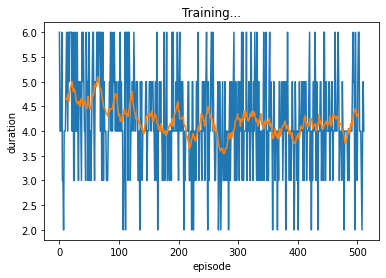

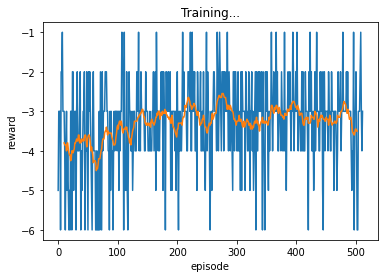

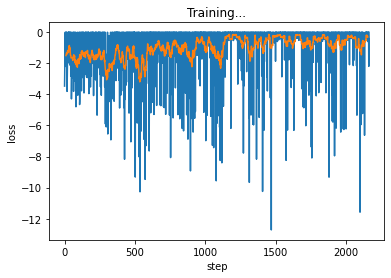

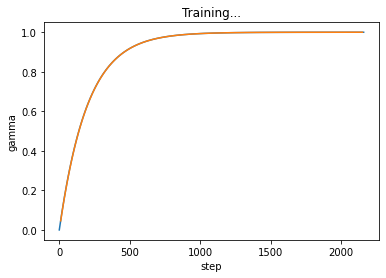

In [13]:
plot_all(*run_experiment(
    model=ModelConfig(name='monte'),
    num_episodes=512,
    training=TrainConfig(optimizer='adam', lr=0.01, batch_size=-1, train_interval=128, clear_memory=True),
    seed=1,
    run_test=True
    ))

=========================episode 0 nanny======================
------guess 0 0 spied-------
reward -1 done False action 0
------guess 1 0 balmy-------
reward -1 done False action 0
------guess 2 1 tronc-------
reward -1 done False action 1
------guess 3 0 nanny-------
reward 0 done True action 0
episode 0 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.014888060396937353  steps 4  memory 0
=========================episode 1 foyer======================
------guess 0 0 again-------
reward -1 done False action 0
------guess 1 0 jerky-------
reward -1 done False action 0
------guess 2 1 colts-------
reward -1 done False action 1
------guess 3 0 foyer-------
reward 0 done True action 0
episode 1 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.03439458374243354  steps 8  memory 4
=========================episode 2 joint======================
------guess 0 0 fecal-------
reward -1 done False action 0
------guess 1 1 riots-------
reward -1 done False action 1
------guess 2 1 dungy-----

------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 layer-------
reward 0 done True action 0
episode 19 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.3655520320517718  steps 92  memory 89
=========================episode 20 spice======================
------guess 0 0 wrung-------
reward -1 done False action 0
------guess 1 1 toeas-------
reward -1 done False action 1
------guess 2 1 hylic-------
reward -1 done False action 1
------guess 3 1 dempt-------
reward -1 done False action 1
------guess 4 0 spice-------
reward 0 done True action 0
episode 20 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.38121660819385916  steps 97  memory 92
=========================episode 21 paper======================
------guess 0 0 posse-------
reward -1 done False action 0
------guess 1 1 liart-------
reward -1 done False action 1
------guess 2 0 paper-------
reward 0 done True action 0
episode 21 finished.  rewa

------guess 1 0 crude-------
reward -1 done False action 0
------guess 2 0 curse-------
reward 0 done True action 0
episode 38 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.5954581148969812  steps 182  memory 179
=========================episode 39 infer======================
------guess 0 0 rupee-------
reward -1 done False action 0
------guess 1 0 waver-------
reward -1 done False action 0
------guess 2 0 inner-------
reward -1 done False action 0
------guess 3 1 colts-------
reward -1 done False action 1
------guess 4 1 hedgy-------
reward -1 done False action 1
------guess 5 1 bumfs-------
reward -1 done True action 1
episode 39 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.6074141344684816  steps 188  memory 182
=========================episode 40 toddy======================
------guess 0 0 whelp-------
reward -1 done False action 0
------guess 1 1 ratio-------
reward -1 done False action 1
------guess 2 1 dungs-------
reward -1 done False action 1
------guess 3 0 todd

------guess 3 1 whump-------
reward -1 done False action 1
------guess 4 0 venom-------
reward -1 done False action 0
------guess 5 1 fyked-------
reward -1 done True action 1
episode 57 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.7394602921400244  steps 270  memory 264
=========================episode 58 alley======================
------guess 0 0 grand-------
reward -1 done False action 0
------guess 1 0 taboo-------
reward -1 done False action 0
------guess 2 0 apply-------
reward -1 done False action 0
------guess 3 0 allay-------
reward -1 done False action 0
------guess 4 1 iches-------
reward -1 done False action 1
------guess 5 1 muzak-------
reward -1 done True action 1
episode 58 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.7471604041952535  steps 276  memory 270
=========================episode 59 stole======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 sto

------guess 1 0 brain-------
reward -1 done False action 0
------guess 2 0 going-------
reward -1 done False action 0
------guess 3 0 inlet-------
reward -1 done False action 0
------guess 4 1 chums-------
reward -1 done False action 1
------guess 5 0 index-------
reward 0 done True action 0
episode 76 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.836345863197296  steps 363  memory 357
=========================episode 77 brain======================
------guess 0 0 unwed-------
reward -1 done False action 0
------guess 1 0 baton-------
reward -1 done False action 0
------guess 2 1 cirls-------
reward -1 done False action 1
------guess 3 0 brain-------
reward 0 done True action 0
episode 77 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.8395864322248272  steps 367  memory 363
=========================episode 78 swash======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 psalm-------
reward -1 done False action 0
------guess 2 0 shank-

------guess 1 1 stair-------
reward -1 done False action 1
------guess 2 0 macro-------
reward 0 done True action 0
episode 95 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.8924715698642051  steps 447  memory 444
=========================episode 96 pouty======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 pouty-------
reward 0 done True action 0
episode 96 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.8940724596264547  steps 450  memory 447
=========================episode 97 whisk======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 skull-------
reward -1 done False action 0
------guess 2 1 pinch-------
reward -1 done False action 1
------guess 3 0 whisk-------
reward 0 done True action 0
episode 97 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.896169965459203  steps 454  memory 450
=========================episode 98 ted

------guess 3 1 champ-------
reward -1 done False action 1
------guess 4 1 budge-------
reward -1 done False action 1
------guess 5 1 flaws-------
reward -1 done True action 1
episode 115 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.9307477746906541  steps 535  memory 529
=========================episode 116 chime======================
------guess 0 0 tower-------
reward -1 done False action 0
------guess 1 1 snail-------
reward -1 done False action 1
------guess 2 0 chide-------
reward -1 done False action 0
------guess 3 0 chime-------
reward 0 done True action 0
episode 116 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9321190606282386  steps 539  memory 535
=========================episode 117 humid======================
------guess 0 0 ripen-------
reward -1 done False action 0
------guess 1 1 altos-------
reward -1 done False action 1
------guess 2 1 duchy-------
reward -1 done False action 1
------guess 3 0 humid-------
reward 0 done True action 0
episode 117 finish

------guess 4 0 apple-------
reward 0 done True action 0
episode 134 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9553990446597255  steps 623  memory 26
=========================episode 135 spelt======================
------guess 0 0 gipsy-------
reward -1 done False action 0
------guess 1 0 pesto-------
reward -1 done False action 0
------guess 2 0 spent-------
reward -1 done False action 0
------guess 3 0 spelt-------
reward 0 done True action 0
episode 135 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9562822027472491  steps 627  memory 31
=========================episode 136 cargo======================
------guess 0 0 amber-------
reward -1 done False action 0
------guess 1 0 crank-------
reward -1 done False action 0
------guess 2 0 carol-------
reward -1 done False action 0
------guess 3 0 cargo-------
reward 0 done True action 0
episode 136 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9571478731329598  steps 631  memory 35
=========================episode 137

------guess 1 0 phase-------
reward -1 done False action 0
------guess 2 0 creak-------
reward -1 done False action 0
------guess 3 0 rebar-------
reward -1 done False action 0
------guess 4 0 regal-------
reward -1 done False action 0
------guess 5 0 relax-------
reward -1 done True action 0
episode 155 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.9709866729178029  steps 709  memory 111
=========================episode 156 bicep======================
------guess 0 0 horny-------
reward -1 done False action 0
------guess 1 0 cleft-------
reward -1 done False action 0
------guess 2 0 juice-------
reward -1 done False action 0
------guess 3 0 medic-------
reward -1 done False action 0
------guess 4 0 bicep-------
reward 0 done True action 0
episode 156 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9717030145158132  steps 714  memory 117
=========================episode 157 dryly======================
------guess 0 0 dirge-------
reward -1 done False action 0
------guess 1 0 

------guess 2 0 syrup-------
reward 0 done True action 0
episode 175 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9806487836303224  steps 790  memory 195
=========================episode 176 gloom======================
------guess 0 0 erase-------
reward -1 done False action 0
------guess 1 0 flown-------
reward -1 done False action 0
------guess 2 0 bloom-------
reward -1 done False action 0
------guess 3 0 gloom-------
reward 0 done True action 0
episode 176 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.98103196338757  steps 794  memory 198
=========================episode 177 twirl======================
------guess 0 0 chord-------
reward -1 done False action 0
------guess 1 0 twirl-------
reward 0 done True action 0
episode 177 finished.  reward -1  eps [0.9, 0.05, 200]  gamma 0.9812206985053156  steps 796  memory 202
=========================episode 178 girth======================
------guess 0 0 ladle-------
reward -1 done False action 0
------guess 1 0 ionic-------


------guess 3 0 never-------
reward 0 done True action 0
episode 198 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.987844821670085  steps 883  memory 287
=========================episode 199 click======================
------guess 0 0 mafia-------
reward -1 done False action 0
------guess 1 0 silky-------
reward -1 done False action 0
------guess 2 0 clink-------
reward -1 done False action 0
------guess 3 0 click-------
reward 0 done True action 0
episode 199 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9880855103272104  steps 887  memory 291
=========================episode 200 chill======================
------guess 0 0 farce-------
reward -1 done False action 0
------guess 1 0 chili-------
reward -1 done False action 0
------guess 2 0 chill-------
reward 0 done True action 0
episode 200 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9882628939690575  steps 890  memory 295
=========================episode 201 abide======================
------guess 0 0 bulge-------

------guess 2 0 comic-------
reward -1 done False action 0
------guess 3 0 motif-------
reward 0 done True action 0
episode 219 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9918927779220973  steps 964  memory 368
=========================episode 220 acute======================
------guess 0 0 badly-------
reward -1 done False action 0
------guess 1 0 vicar-------
reward -1 done False action 0
------guess 2 0 chaos-------
reward -1 done False action 0
------guess 3 0 acute-------
reward 0 done True action 0
episode 220 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9920533116750365  steps 968  memory 372
=========================episode 221 flora======================
------guess 0 0 shirk-------
reward -1 done False action 0
------guess 1 0 macro-------
reward -1 done False action 0
------guess 2 0 opera-------
reward -1 done False action 0
------guess 3 0 flora-------
reward 0 done True action 0
episode 221 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.99221066664668

------guess 1 0 haven-------
reward -1 done False action 0
------guess 2 0 coven-------
reward -1 done False action 0
------guess 3 0 seven-------
reward -1 done False action 0
------guess 4 0 given-------
reward 0 done True action 0
episode 240 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9946997431641296  steps 1049  memory 452
=========================episode 241 stare======================
------guess 0 0 panic-------
reward -1 done False action 0
------guess 1 0 grade-------
reward -1 done False action 0
------guess 2 0 share-------
reward -1 done False action 0
------guess 3 0 stare-------
reward 0 done True action 0
episode 241 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9948046952812948  steps 1053  memory 457
=========================episode 242 outgo======================
------guess 0 0 tonic-------
reward -1 done False action 0
------guess 1 0 afoot-------
reward -1 done False action 0
------guess 2 0 outgo-------
reward 0 done True action 0
episode 242 finis

------guess 2 0 baste-------
reward -1 done False action 0
------guess 3 0 elate-------
reward -1 done False action 0
------guess 4 0 plate-------
reward 0 done True action 0
episode 261 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9966204070306233  steps 1139  memory 20
=========================episode 262 whelp======================
------guess 0 0 bongo-------
reward -1 done False action 0
------guess 1 0 spare-------
reward -1 done False action 0
------guess 2 0 plied-------
reward -1 done False action 0
------guess 3 0 whelp-------
reward 0 done True action 0
episode 262 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9966873274551001  steps 1143  memory 25
=========================episode 263 blaze======================
------guess 0 0 steep-------
reward -1 done False action 0
------guess 1 0 angel-------
reward -1 done False action 0
------guess 2 0 relax-------
reward -1 done False action 0
------guess 3 0 fable-------
reward -1 done False action 0
------guess 4 0 b

------guess 2 0 bluer-------
reward -1 done False action 0
------guess 3 0 rouse-------
reward -1 done False action 0
------guess 4 0 azure-------
reward 0 done True action 0
episode 282 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9978450763817024  steps 1229  memory 110
=========================episode 283 dusty======================
------guess 0 0 genre-------
reward -1 done False action 0
------guess 1 0 aloof-------
reward -1 done False action 0
------guess 2 0 juicy-------
reward -1 done False action 0
------guess 3 0 hussy-------
reward -1 done False action 0
------guess 4 0 dusty-------
reward 0 done True action 0
episode 283 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9978982816354104  steps 1234  memory 115
=========================episode 284 roger======================
------guess 0 0 fresh-------
reward -1 done False action 0
------guess 1 0 rebel-------
reward -1 done False action 0
------guess 2 0 raven-------
reward -1 done False action 0
------guess 3 0

------guess 1 0 inter-------
reward -1 done False action 0
------guess 2 0 bathe-------
reward -1 done False action 0
------guess 3 0 butte-------
reward 0 done True action 0
episode 303 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9986259600363788  steps 1319  memory 201
=========================episode 304 torch======================
------guess 0 0 diary-------
reward -1 done False action 0
------guess 1 0 roger-------
reward -1 done False action 0
------guess 2 0 honor-------
reward -1 done False action 0
------guess 3 0 porch-------
reward -1 done False action 0
------guess 4 0 torch-------
reward 0 done True action 0
episode 304 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9986598852039572  steps 1324  memory 205
=========================episode 305 posit======================
------guess 0 0 shaft-------
reward -1 done False action 0
------guess 1 0 crest-------
reward -1 done False action 0
------guess 2 0 posit-------
reward 0 done True action 0
episode 305 finis

------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 daily-------
reward -1 done False action 0
------guess 2 0 final-------
reward -1 done False action 0
------guess 3 0 lilac-------
reward 0 done True action 0
episode 324 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9991016941882236  steps 1404  memory 286
=========================episode 325 manga======================
------guess 0 0 enemy-------
reward -1 done False action 0
------guess 1 0 minus-------
reward -1 done False action 0
------guess 2 0 month-------
reward -1 done False action 0
------guess 3 0 manga-------
reward 0 done True action 0
episode 325 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9991194818350729  steps 1408  memory 290
=========================episode 326 flunk======================
------guess 0 0 honor-------
reward -1 done False action 0
------guess 1 0 being-------
reward -1 done False action 0
------guess 2 0 vaunt-------
reward -1 done False action 0
------guess 3 0

------guess 3 0 cruel-------
reward -1 done False action 0
------guess 4 0 excel-------
reward 0 done True action 0
episode 344 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9994097710231509  steps 1488  memory 369
=========================episode 345 spree======================
------guess 0 0 snowy-------
reward -1 done False action 0
------guess 1 0 strut-------
reward -1 done False action 0
------guess 2 0 scrap-------
reward -1 done False action 0
------guess 3 0 sprig-------
reward -1 done False action 0
------guess 4 0 spree-------
reward 0 done True action 0
episode 345 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9994243438285128  steps 1493  memory 374
=========================episode 346 savvy======================
------guess 0 0 jumbo-------
reward -1 done False action 0
------guess 1 0 dizzy-------
reward -1 done False action 0
------guess 2 0 leggy-------
reward -1 done False action 0
------guess 3 0 happy-------
reward -1 done False action 0
------guess 4 0

=========================episode 368 whiny======================
------guess 0 0 index-------
reward -1 done False action 0
------guess 1 0 final-------
reward -1 done False action 0
------guess 2 0 scion-------
reward -1 done False action 0
------guess 3 0 briny-------
reward -1 done False action 0
------guess 4 0 whiny-------
reward 0 done True action 0
episode 368 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.999636597673505  steps 1585  memory 466
=========================episode 369 splat======================
------guess 0 0 tulle-------
reward -1 done False action 0
------guess 1 0 splat-------
reward 0 done True action 0
episode 369 finished.  reward -1  eps [0.9, 0.05, 200]  gamma 0.9996402135870696  steps 1587  memory 471
=========================episode 370 hyper======================
------guess 0 0 fetus-------
reward -1 done False action 0
------guess 1 0 money-------
reward -1 done False action 0
------guess 2 0 payee-------
reward -1 done False action 0
------gues

------guess 1 0 meter-------
reward 0 done True action 0
episode 391 finished.  reward -1  eps [0.9, 0.05, 200]  gamma 0.9997694401324075  steps 1676  memory 31
=========================episode 392 gruel======================
------guess 0 0 ladle-------
reward -1 done False action 0
------guess 1 0 relic-------
reward -1 done False action 0
------guess 2 0 flyer-------
reward -1 done False action 0
------guess 3 0 gruel-------
reward 0 done True action 0
episode 392 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9997740055236681  steps 1680  memory 33
=========================episode 393 modal======================
------guess 0 0 grout-------
reward -1 done False action 0
------guess 1 0 salon-------
reward -1 done False action 0
------guess 2 0 offal-------
reward -1 done False action 0
------guess 3 0 vocal-------
reward -1 done False action 0
------guess 4 0 loyal-------
reward -1 done False action 0
------guess 5 0 modal-------
reward 0 done True action 0
episode 393 finishe

------guess 2 0 lease-------
reward -1 done False action 0
------guess 3 0 expel-------
reward 0 done True action 0
episode 412 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9998500187092529  steps 1762  memory 115
=========================episode 413 shaft======================
------guess 0 0 trout-------
reward -1 done False action 0
------guess 1 0 faint-------
reward -1 done False action 0
------guess 2 0 shaft-------
reward 0 done True action 0
episode 413 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.999852251639768  steps 1765  memory 119
=========================episode 414 grime======================
------guess 0 0 afoul-------
reward -1 done False action 0
------guess 1 0 dirty-------
reward -1 done False action 0
------guess 2 0 prick-------
reward -1 done False action 0
------guess 3 0 bribe-------
reward -1 done False action 0
------guess 4 0 grime-------
reward 0 done True action 0
episode 414 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9998558995597

------guess 2 0 tally-------
reward -1 done False action 0
------guess 3 0 badly-------
reward -1 done False action 0
------guess 4 0 daily-------
reward 0 done True action 0
episode 433 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9999038883479386  steps 1851  memory 203
=========================episode 434 roost======================
------guess 0 0 dried-------
reward -1 done False action 0
------guess 1 0 surly-------
reward -1 done False action 0
------guess 2 0 roost-------
reward 0 done True action 0
episode 434 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9999053192640194  steps 1854  memory 208
=========================episode 435 dross======================
------guess 0 0 range-------
reward -1 done False action 0
------guess 1 0 sport-------
reward -1 done False action 0
------guess 2 0 cross-------
reward -1 done False action 0
------guess 3 0 dross-------
reward 0 done True action 0
episode 435 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.999907194068

=========================episode 454 mafia======================
------guess 0 0 grove-------
reward -1 done False action 0
------guess 1 0 await-------
reward -1 done False action 0
------guess 2 0 mafia-------
reward 0 done True action 0
episode 454 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9999362154780684  steps 1933  memory 287
=========================episode 455 dross======================
------guess 0 0 lucky-------
reward -1 done False action 0
------guess 1 0 dried-------
reward -1 done False action 0
------guess 2 0 drama-------
reward -1 done False action 0
------guess 3 0 drown-------
reward -1 done False action 0
------guess 4 0 droop-------
reward -1 done False action 0
------guess 5 0 dross-------
reward 0 done True action 0
episode 455 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.999938100595582  steps 1939  memory 290
=========================episode 456 truly======================
------guess 0 0 crick-------
reward -1 done False action 0
------gues

------guess 4 0 mauve-------
reward 0 done True action 0
episode 474 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9999589204447747  steps 2021  memory 373
=========================episode 475 singe======================
------guess 0 0 gonad-------
reward -1 done False action 0
------guess 1 0 hinge-------
reward -1 done False action 0
------guess 2 0 singe-------
reward 0 done True action 0
episode 475 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.999959532039674  steps 2024  memory 378
=========================episode 476 croak======================
------guess 0 0 bench-------
reward -1 done False action 0
------guess 1 0 caulk-------
reward -1 done False action 0
------guess 2 0 croak-------
reward 0 done True action 0
episode 476 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9999601345291115  steps 2027  memory 381
=========================episode 477 shock======================
------guess 0 0 navel-------
reward -1 done False action 0
------guess 1 0 wispy----

------guess 1 0 trice-------
reward -1 done False action 0
------guess 2 0 imbue-------
reward -1 done False action 0
------guess 3 0 liege-------
reward -1 done False action 0
------guess 4 0 hinge-------
reward 0 done True action 0
episode 497 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9999734106553634  steps 2108  memory 460
=========================episode 498 vinyl======================
------guess 0 0 nosey-------
reward -1 done False action 0
------guess 1 0 lynch-------
reward -1 done False action 0
------guess 2 0 vinyl-------
reward 0 done True action 0
episode 498 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9999738065191323  steps 2111  memory 465
=========================episode 499 kinky======================
------guess 0 0 grave-------
reward -1 done False action 0
------guess 1 0 hunch-------
reward -1 done False action 0
------guess 2 0 windy-------
reward -1 done False action 0
------guess 3 0 pinky-------
reward -1 done False action 0
------guess 4 0

light 5
those 4
moist 4
shard 4
pleat 5
aloft 4
skill 0
elder 4
frame 4
humor 4
pause 3
ulcer 4
ultra 3
robin 3
cynic 3
agora 4
aroma 4
caulk 4
shake 5
pupal 4
dodge 4
swill 3
tacit 4
other 3
thorn 3
trove 4
bloke 4
vivid 4
spill 6
chant 3
choke 3
rupee 4
nasty 4
mourn 4
ahead 4
brine 5
cloth 4
hoard 4
sweet 5
month 6
lapse 5
watch 6
today 0
focus 3
smelt 5
tease 4
cater 4
movie 3
lynch 4
saute 4
allow 3
renew 2
their 3
slosh 3
purge 3
chest 4
depot 3
epoxy 2
nymph 5
found 0
shall 3
harry 4
stove 6
lowly 5
snout 4
trope 4
fewer 5
shawl 4
natal 5
fibre 4
comma 3
foray 4
scare 3
stair 3
black 2
squad 4
royal 4
chunk 3
mince 6
slave 4
shame 3
cheek 3
ample 5
flair 3
foyer 4
cargo 5
oxide 4
plant 3
olive 2
inert 4
askew 4
heist 4
shown 5
zesty 4
hasty 3
trash 2
fella 4
larva 4
forgo 4
story 3
hairy 0
train 4
homer 0
badge 5
midst 3
canny 5
fetus 4
butch 3
farce 4
slung 3
tipsy 3
metal 4
yield 4
delve 3
being 3
scour 3
glass 4
gamer 2
scrap 5
money 4
hinge 4
album 4
vouch 6
asset 3
tiara 3


arose 5
motif 2
smash 5
broil 3
glare 3
shove 4
baggy 3
mammy 0
swamp 3
along 4
rugby 4
wager 6
quack 6
squat 5
snaky 6
debit 2
mange 4
skate 0
ninth 4
joust 5
tramp 3
spurn 3
medal 4
micro 3
rebel 4
flank 6
learn 5
nadir 3
maple 5
comfy 4
remit 4
gruff 5
ester 3
least 5
mogul 5
fetch 5
cause 4
oaken 3
aglow 3
meaty 4
gaffe 6
shyly 4
racer 3
prowl 5
thief 5
stern 5
poesy 4
rocky 5
tweet 4
waist 4
spire 5
grope 4
havoc 5
patsy 2
truly 5
forty 4
deity 3
uncle 4
swish 5
giver 6
preen 5
bevel 4
lemur 4
draft 4
slope 4
annoy 4
lingo 4
bleak 4
ditty 5
curly 5
cedar 4
dirge 3
grown 6
horde 4
drool 3
shuck 5
crypt 2
cumin 4
stock 5
gravy 4
locus 4
wider 6
breed 4
quite 4
chafe 4
cache 4
blimp 5
deign 4
fiend 2
logic 3
cheap 4
elide 5
rigid 4
false 3
renal 5
pence 4
rowdy 3
shoot 5
blaze 4
envoy 4
posse 3
brief 4
never 2
abort 3
mouse 5
mucky 5
sulky 3
fiery 4
media 3
trunk 6
yeast 5
clear 3
skunk 6
scalp 2
bitty 4
cider 0
koala 3
duvet 3
segue 4
creme 4
super 4
grill 5
after 5
owner 6
ember 4


scram 4
manly 4
hello 4
vaunt 5
organ 4
feral 4
knock 4
extra 4
condo 4
adapt 4
willy 0
polka 3
rayon 3
skirt 4
faith 6
torso 3
match 2
mercy 5
tepid 5
sleek 3
riser 3
twixt 4
peace 3
flush 5
catty 6
login 5
eject 4
roger 6
rival 4
untie 4
refit 4
aorta 4
adult 3
judge 4
rower 5
artsy 3
rural 4
shave 6
0: 43
1: 1
2: 75
3: 538
4: 941
5: 536
6: 181


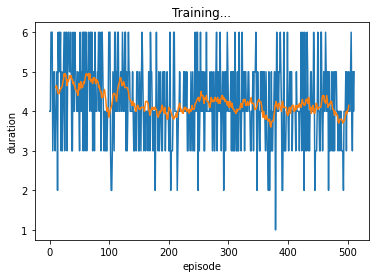

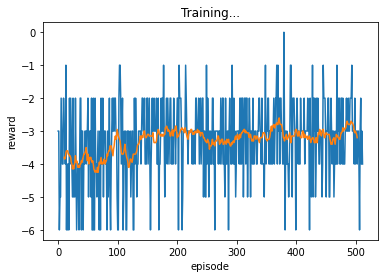

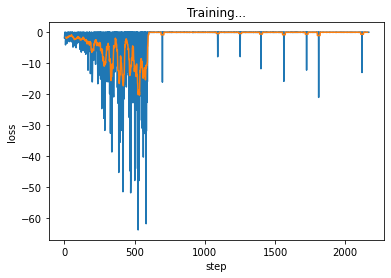

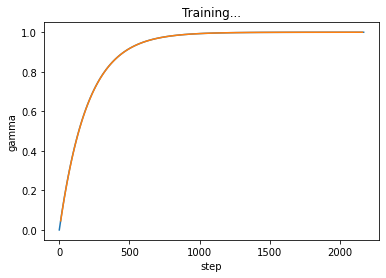

In [14]:
plot_all(*run_experiment(
    model=ModelConfig(name='linear'),
    num_episodes=512,
    training=TrainConfig(optimizer='rmprop', lr=0.01, batch_size=-1, train_interval=128, clear_memory=True),
    seed=1,
    run_test=True
    ))

=========================episode 0 nanny======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 mangy-------
reward -1 done False action 0
------guess 3 0 candy-------
reward -1 done False action 0
------guess 4 0 fanny-------
reward -1 done False action 0
------guess 5 0 nanny-------
reward 0 done True action 0
episode 0 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.024690087971667385  steps 6  memory 0
=========================episode 1 clout======================
------guess 0 0 extra-------
reward -1 done False action 0
------guess 1 0 uncut-------
reward -1 done False action 0
------guess 2 1 soily-------
reward -1 done False action 1
------guess 3 1 bumph-------
reward -1 done False action 1
------guess 4 1 fadge-------
reward -1 done False action 1
------guess 5 1 twank-------
reward -1 done True action 1
episode 1 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.0535148

------guess 5 1 fives-------
reward -1 done True action 1
episode 18 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.36237184837822667  steps 91  memory 85
=========================episode 19 nosey======================
------guess 0 0 plier-------
reward -1 done False action 0
------guess 1 1 santo-------
reward -1 done False action 1
------guess 2 1 duchy-------
reward -1 done False action 1
------guess 3 1 begum-------
reward -1 done False action 1
------guess 4 0 nosey-------
reward 0 done True action 0
episode 19 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.3781149435349799  steps 96  memory 91
=========================episode 20 mamma======================
------guess 0 0 early-------
reward -1 done False action 0
------guess 1 1 oints-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 1 debug-------
reward -1 done False action 1
------guess 4 0 mamma-------
reward 0 done True action 0
episode 20 finished.  rew

------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 1 gybed-------
reward -1 done False action 1
------guess 4 1 wakfs-------
reward -1 done False action 1
------guess 5 0 jewel-------
reward 0 done True action 0
episode 38 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.597475775966364  steps 183  memory 177
=========================episode 39 spicy======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 slush-------
reward -1 done False action 0
------guess 2 1 mincy-------
reward -1 done False action 1
------guess 3 1 podge-------
reward -1 done False action 1
------guess 4 0 spicy-------
reward 0 done True action 0
episode 39 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.6074141344684816  steps 188  memory 183
=========================episode 40 flail======================
------guess 0 1 roate-

------guess 2 1 linch-------
reward -1 done False action 1
------guess 3 0 stale-------
reward 0 done True action 0
episode 58 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.7341970409110734  steps 266  memory 262
=========================episode 59 finch======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 fungi-------
reward -1 done False action 0
------guess 3 0 finch-------
reward 0 done True action 0
episode 59 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.7394602921400244  steps 270  memory 266
=========================episode 60 decry======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 0 decry-------
reward 0 done True action 0
episode 60 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.7446193240119223  s

------guess 1 1 rotal-------
reward -1 done False action 1
------guess 2 1 dishy-------
reward -1 done False action 1
------guess 3 0 glaze-------
reward -1 done False action 0
------guess 4 1 plumb-------
reward -1 done False action 1
------guess 5 0 blaze-------
reward 0 done True action 0
episode 79 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.8296670111745905  steps 355  memory 349
=========================episode 80 bloom======================
------guess 0 0 posit-------
reward -1 done False action 0
------guess 1 1 neral-------
reward -1 done False action 1
------guess 2 1 duchy-------
reward -1 done False action 1
------guess 3 0 gloom-------
reward -1 done False action 0
------guess 4 1 bawks-------
reward -1 done False action 1
------guess 5 0 bloom-------
reward 0 done True action 0
episode 80 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.8347011117784134  steps 361  memory 355
=========================episode 81 vying======================
------guess 0 1 oater

------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 yearn-------
reward 0 done True action 0
episode 98 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.8891968416376661  steps 441  memory 438
=========================episode 99 whiff======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 chick-------
reward -1 done False action 0
------guess 3 1 dumpy-------
reward -1 done False action 1
------guess 4 0 whiff-------
reward 0 done True action 0
episode 99 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.8919325813651707  steps 446  memory 441
=========================episode 100 outdo======================
------guess 0 0 sally-------
reward -1 done False action 0
------guess 1 1 noter-------
reward -1 done False action 1
------guess 2 1 cupid-------
reward -1 done False action 1
------guess 3 0 outd

------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 flare-------
reward -1 done False action 0
------guess 3 0 glare-------
reward 0 done True action 0
episode 118 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9282810305914092  steps 528  memory 524
=========================episode 119 baler======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 layer-------
reward -1 done False action 0
------guess 2 0 baler-------
reward 0 done True action 0
episode 119 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9293487869395705  steps 531  memory 528
=========================episode 120 leash======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 leash-------
reward 0 done True action 0
episode 120 finished.  reward -1  eps [0.9, 0.05, 200]  gamma 0.9300517782553447  steps 533  memory 531
=========================episode 121 skulk======================
------guess 0 1 roate------

------guess 1 0 drink-------
reward -1 done False action 0
------guess 2 0 fruit-------
reward -1 done False action 0
------guess 3 0 orbit-------
reward 0 done True action 0
episode 138 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9540407433509558  steps 617  memory 43
=========================episode 139 arrow======================
------guess 0 0 downy-------
reward -1 done False action 0
------guess 1 0 below-------
reward -1 done False action 0
------guess 2 0 throw-------
reward -1 done False action 0
------guess 3 0 arrow-------
reward 0 done True action 0
episode 139 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9549507976064422  steps 621  memory 47
=========================episode 140 inbox======================
------guess 0 0 stair-------
reward -1 done False action 0
------guess 1 0 icing-------
reward -1 done False action 0
------guess 2 0 inbox-------
reward 0 done True action 0
episode 140 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9556214928525113

------guess 3 0 crony-------
reward 0 done True action 0
episode 159 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9702521970459025  steps 704  memory 130
=========================episode 160 cameo======================
------guess 0 0 loyal-------
reward -1 done False action 0
------guess 1 0 ascot-------
reward -1 done False action 0
------guess 2 0 cargo-------
reward -1 done False action 0
------guess 3 0 cameo-------
reward 0 done True action 0
episode 160 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9708412430106028  steps 708  memory 134
=========================episode 161 trend======================
------guess 0 0 leaky-------
reward -1 done False action 0
------guess 1 0 ridge-------
reward -1 done False action 0
------guess 2 0 breed-------
reward -1 done False action 0
------guess 3 0 trend-------
reward 0 done True action 0
episode 161 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9714186250837188  steps 712  memory 138
=========================episode 

------guess 1 0 ozone-------
reward -1 done False action 0
------guess 2 0 imbue-------
reward -1 done False action 0
------guess 3 0 spice-------
reward -1 done False action 0
------guess 4 0 chide-------
reward 0 done True action 0
episode 183 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9812206985053156  steps 796  memory 221
=========================episode 184 nutty======================
------guess 0 0 erase-------
reward -1 done False action 0
------guess 1 0 flown-------
reward -1 done False action 0
------guess 2 0 nymph-------
reward -1 done False action 0
------guess 3 0 ninny-------
reward -1 done False action 0
------guess 4 0 nutty-------
reward 0 done True action 0
episode 184 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9816843611112658  steps 801  memory 226
=========================episode 185 creep======================
------guess 0 0 chord-------
reward -1 done False action 0
------guess 1 0 crier-------
reward -1 done False action 0
------guess 2 0 c

------guess 1 0 extra-------
reward -1 done False action 0
------guess 2 0 ratty-------
reward -1 done False action 0
------guess 3 0 ratio-------
reward 0 done True action 0
episode 204 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9881449340923619  steps 888  memory 314
=========================episode 205 unwed======================
------guess 0 0 zesty-------
reward -1 done False action 0
------guess 1 0 exile-------
reward -1 done False action 0
------guess 2 0 paper-------
reward -1 done False action 0
------guess 3 0 unfed-------
reward -1 done False action 0
------guess 4 0 unwed-------
reward 0 done True action 0
episode 205 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9884376367125315  steps 893  memory 318
=========================episode 206 braid======================
------guess 0 0 lease-------
reward -1 done False action 0
------guess 1 0 brawn-------
reward -1 done False action 0
------guess 2 0 bravo-------
reward -1 done False action 0
------guess 3 0 b

------guess 2 0 minim-------
reward -1 done False action 0
------guess 3 0 whisk-------
reward -1 done False action 0
------guess 4 0 skiff-------
reward -1 done False action 0
------guess 5 0 skirt-------
reward 0 done True action 0
episode 224 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.99236490578114  steps 976  memory 400
=========================episode 225 twirl======================
------guess 0 0 visit-------
reward -1 done False action 0
------guess 1 0 tulip-------
reward -1 done False action 0
------guess 2 0 twirl-------
reward 0 done True action 0
episode 225 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9924785775250067  steps 979  memory 406
=========================episode 226 great======================
------guess 0 0 check-------
reward -1 done False action 0
------guess 1 0 enemy-------
reward -1 done False action 0
------guess 2 0 ideal-------
reward -1 done False action 0
------guess 3 0 sweat-------
reward -1 done False action 0
------guess 4 0 gre

------guess 4 0 focal-------
reward 0 done True action 0
episode 245 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9950084060930898  steps 1061  memory 486
=========================episode 246 soggy======================
------guess 0 0 riper-------
reward -1 done False action 0
------guess 1 0 salty-------
reward -1 done False action 0
------guess 2 0 snowy-------
reward -1 done False action 0
------guess 3 0 soggy-------
reward 0 done True action 0
episode 246 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9951072462747605  steps 1065  memory 491
=========================episode 247 peace======================
------guess 0 0 spare-------
reward -1 done False action 0
------guess 1 0 agape-------
reward -1 done False action 0
------guess 2 0 plate-------
reward -1 done False action 0
------guess 3 0 peace-------
reward 0 done True action 0
episode 247 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9952041292897036  steps 1069  memory 495
=========================episo

------guess 5 0 dully-------
reward 0 done True action 0
episode 266 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.996769117631655  steps 1148  memory 43
=========================episode 267 truer======================
------guess 0 0 befit-------
reward -1 done False action 0
------guess 1 0 ethos-------
reward -1 done False action 0
------guess 2 0 cater-------
reward -1 done False action 0
------guess 3 0 truer-------
reward 0 done True action 0
episode 267 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9968330933889381  steps 1152  memory 49
=========================episode 268 clued======================
------guess 0 0 axiom-------
reward -1 done False action 0
------guess 1 0 burly-------
reward -1 done False action 0
------guess 2 0 pluck-------
reward -1 done False action 0
------guess 3 0 clued-------
reward 0 done True action 0
episode 268 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9968958023413507  steps 1156  memory 53
=========================episode 2

------guess 1 0 fifty-------
reward -1 done False action 0
------guess 2 0 bison-------
reward -1 done False action 0
------guess 3 0 cinch-------
reward -1 done False action 0
------guess 4 0 winch-------
reward -1 done False action 0
------guess 5 0 pinch-------
reward 0 done True action 0
episode 287 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9979087639994849  steps 1235  memory 130
=========================episode 288 gaunt======================
------guess 0 0 filer-------
reward -1 done False action 0
------guess 1 0 wagon-------
reward -1 done False action 0
------guess 2 0 gaunt-------
reward 0 done True action 0
episode 288 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9979398984473649  steps 1238  memory 136
=========================episode 289 azure======================
------guess 0 0 vivid-------
reward -1 done False action 0
------guess 1 0 erupt-------
reward -1 done False action 0
------guess 2 0 bluer-------
reward -1 done False action 0
------guess 3 0

------guess 1 0 sauce-------
reward -1 done False action 0
------guess 2 0 earth-------
reward 0 done True action 0
episode 308 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.998646416826345  steps 1322  memory 220
=========================episode 309 cleft======================
------guess 0 0 dream-------
reward -1 done False action 0
------guess 1 0 beefy-------
reward -1 done False action 0
------guess 2 0 cleft-------
reward 0 done True action 0
episode 309 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9986665690543867  steps 1325  memory 223
=========================episode 310 tenet======================
------guess 0 0 shoot-------
reward -1 done False action 0
------guess 1 0 audit-------
reward -1 done False action 0
------guess 2 0 tweet-------
reward -1 done False action 0
------guess 3 0 tenet-------
reward 0 done True action 0
episode 310 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9986929727561636  steps 1329  memory 226
=========================episod

------guess 2 0 tempo-------
reward -1 done False action 0
------guess 3 0 pivot-------
reward -1 done False action 0
------guess 4 0 optic-------
reward 0 done True action 0
episode 330 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.999132591042693  steps 1411  memory 307
=========================episode 331 paddy======================
------guess 0 0 thick-------
reward -1 done False action 0
------guess 1 0 borne-------
reward -1 done False action 0
------guess 2 0 salsa-------
reward -1 done False action 0
------guess 3 0 daddy-------
reward -1 done False action 0
------guess 4 0 paddy-------
reward 0 done True action 0
episode 331 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9991540074461563  steps 1416  memory 312
=========================episode 332 bunny======================
------guess 0 0 purer-------
reward -1 done False action 0
------guess 1 0 quasi-------
reward -1 done False action 0
------guess 2 0 dully-------
reward -1 done False action 0
------guess 3 0 

------guess 1 0 aroma-------
reward -1 done False action 0
------guess 2 0 slime-------
reward -1 done False action 0
------guess 3 0 blimp-------
reward 0 done True action 0
episode 350 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9994272149256459  steps 1494  memory 391
=========================episode 351 foray======================
------guess 0 0 genie-------
reward -1 done False action 0
------guess 1 0 clasp-------
reward -1 done False action 0
------guess 2 0 vodka-------
reward -1 done False action 0
------guess 3 0 foray-------
reward 0 done True action 0
episode 351 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9994385568300281  steps 1498  memory 395
=========================episode 352 skulk======================
------guess 0 0 argue-------
reward -1 done False action 0
------guess 1 0 south-------
reward -1 done False action 0
------guess 2 0 spunk-------
reward -1 done False action 0
------guess 3 0 skulk-------
reward 0 done True action 0
episode 352 finis

------guess 3 0 ninja-------
reward -1 done False action 0
------guess 4 0 aping-------
reward -1 done False action 0
------guess 5 0 axion-------
reward 0 done True action 0
episode 372 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.999632945419405  steps 1583  memory 478
=========================episode 373 slime======================
------guess 0 0 gumbo-------
reward -1 done False action 0
------guess 1 0 medic-------
reward -1 done False action 0
------guess 2 0 impel-------
reward -1 done False action 0
------guess 3 0 slime-------
reward 0 done True action 0
episode 373 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9996402135870696  steps 1587  memory 484
=========================episode 374 cause======================
------guess 0 0 shout-------
reward -1 done False action 0
------guess 1 0 fussy-------
reward -1 done False action 0
------guess 2 0 cause-------
reward 0 done True action 0
episode 374 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9996455701089

------guess 1 0 dopey-------
reward -1 done False action 0
------guess 2 0 spent-------
reward -1 done False action 0
------guess 3 0 snipe-------
reward 0 done True action 0
episode 395 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9997705900545445  steps 1677  memory 44
=========================episode 396 beach======================
------guess 0 0 missy-------
reward -1 done False action 0
------guess 1 0 adult-------
reward -1 done False action 0
------guess 2 0 peace-------
reward -1 done False action 0
------guess 3 0 beach-------
reward 0 done True action 0
episode 396 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9997751326758212  steps 1681  memory 48
=========================episode 397 their======================
------guess 0 0 later-------
reward -1 done False action 0
------guess 1 0 tenor-------
reward -1 done False action 0
------guess 2 0 their-------
reward 0 done True action 0
episode 397 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.99977848051412

------guess 1 0 check-------
reward -1 done False action 0
------guess 2 0 theft-------
reward -1 done False action 0
------guess 3 0 shelf-------
reward 0 done True action 0
episode 419 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9998594574123255  steps 1775  memory 142
=========================episode 420 fungi======================
------guess 0 0 berth-------
reward -1 done False action 0
------guess 1 0 music-------
reward -1 done False action 0
------guess 2 0 quill-------
reward -1 done False action 0
------guess 3 0 fungi-------
reward 0 done True action 0
episode 420 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9998622403420184  steps 1779  memory 146
=========================episode 421 satin======================
------guess 0 0 caper-------
reward -1 done False action 0
------guess 1 0 banal-------
reward -1 done False action 0
------guess 2 0 taint-------
reward -1 done False action 0
------guess 3 0 satin-------
reward 0 done True action 0
episode 421 finis

------guess 3 0 dowdy-------
reward 0 done True action 0
episode 440 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9999094854548244  steps 1863  memory 230
=========================episode 441 feral======================
------guess 0 0 daisy-------
reward -1 done False action 0
------guess 1 0 theta-------
reward -1 done False action 0
------guess 2 0 plane-------
reward -1 done False action 0
------guess 3 0 fecal-------
reward -1 done False action 0
------guess 4 0 feral-------
reward 0 done True action 0
episode 441 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9999117202669074  steps 1868  memory 234
=========================episode 442 jiffy======================
------guess 0 0 scowl-------
reward -1 done False action 0
------guess 1 0 meant-------
reward -1 done False action 0
------guess 2 0 giddy-------
reward -1 done False action 0
------guess 3 0 jiffy-------
reward 0 done True action 0
episode 442 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.999913468322

reward -1 done False action 0
------guess 4 0 slash-------
reward 0 done True action 0
episode 460 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9999414131330512  steps 1950  memory 316
=========================episode 461 beard======================
------guess 0 0 shale-------
reward -1 done False action 0
------guess 1 0 beady-------
reward -1 done False action 0
------guess 2 0 beard-------
reward 0 done True action 0
episode 461 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9999422853778648  steps 1953  memory 321
=========================episode 462 cinch======================
------guess 0 0 stock-------
reward -1 done False action 0
------guess 1 0 lunch-------
reward -1 done False action 0
------guess 2 0 finch-------
reward -1 done False action 0
------guess 3 0 pinch-------
reward -1 done False action 0
------guess 4 0 winch-------
reward -1 done False action 0
------guess 5 0 cinch-------
reward 0 done True action 0
episode 462 finished.  reward -5  eps [0.9, 0.

------guess 1 0 input-------
reward -1 done False action 0
------guess 2 0 clump-------
reward -1 done False action 0
------guess 3 0 pouch-------
reward 0 done True action 0
episode 481 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9999616976765835  steps 2035  memory 402
=========================episode 482 board======================
------guess 0 0 thick-------
reward -1 done False action 0
------guess 1 0 panel-------
reward -1 done False action 0
------guess 2 0 award-------
reward -1 done False action 0
------guess 3 0 guard-------
reward -1 done False action 0
------guess 4 0 board-------
reward 0 done True action 0
episode 482 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9999626433643182  steps 2040  memory 406
=========================episode 483 snore======================
------guess 0 0 louse-------
reward -1 done False action 0
------guess 1 0 shore-------
reward -1 done False action 0
------guess 2 0 spore-------
reward -1 done False action 0
------guess 3 0

------guess 2 0 icing-------
reward -1 done False action 0
------guess 3 0 crown-------
reward -1 done False action 0
------guess 4 0 conch-------
reward -1 done False action 0
------guess 5 0 condo-------
reward 0 done True action 0
episode 500 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9999752082593855  steps 2122  memory 487
=========================episode 501 safer======================
------guess 0 0 tulle-------
reward -1 done False action 0
------guess 1 0 resin-------
reward -1 done False action 0
------guess 2 0 cress-------
reward -1 done False action 0
------guess 3 0 sober-------
reward -1 done False action 0
------guess 4 0 safer-------
reward 0 done True action 0
episode 501 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9999758203696422  steps 2127  memory 493
=========================episode 502 spire======================
------guess 0 0 satyr-------
reward -1 done False action 0
------guess 1 0 serum-------
reward -1 done False action 0
------guess 2 0

brink 6
smite 5
beady 3
rusty 3
retro 4
droll 3
gawky 5
hutch 5
pinto 5
gaily 5
egret 3
lilac 3
sever 4
field 4
fluff 5
hydro 3
flack 4
agape 5
wench 5
voice 3
stead 5
stalk 5
berth 5
madam 4
night 5
bland 6
liver 0
wedge 4
augur 4
roomy 4
wacky 4
flock 4
angry 3
bobby 5
trite 3
aphid 5
tryst 4
midge 6
power 4
elope 4
cinch 3
motto 3
stomp 2
upset 3
bluff 4
cramp 5
quart 3
coyly 3
youth 3
rhyme 4
buggy 4
alien 3
smear 4
unfit 4
patty 4
cling 5
glean 5
label 4
hunky 4
khaki 5
poker 3
gruel 6
twice 4
twang 3
shrug 4
treat 0
unlit 3
waste 0
merit 3
woven 4
octal 3
needy 6
clown 5
widow 3
irony 3
ruder 4
gauze 4
chief 4
onset 3
prize 3
fungi 4
charm 5
gully 4
inter 4
whoop 2
taunt 4
leery 5
class 4
theme 5
lofty 3
tibia 3
booze 4
alpha 3
thyme 4
eclat 4
doubt 3
parer 0
chute 4
stick 6
trice 3
alike 2
sooth 4
recap 4
saint 4
liege 5
glory 4
grate 4
admit 4
brisk 4
soggy 3
usurp 3
scald 6
scorn 4
leave 4
twine 5
sting 3
bough 6
marsh 4
sloth 5
dandy 5
vigor 4
howdy 3
enjoy 4
valid 3
ionic 3


waxen 3
stoic 4
jerky 4
blitz 5
beefy 5
lyric 4
hussy 4
towel 0
quilt 4
below 3
bingo 5
wispy 3
brash 3
scone 4
toast 4
easel 5
saucy 3
value 3
spice 6
honor 5
route 5
sharp 4
bawdy 5
radii 4
skull 4
phony 6
issue 3
lager 5
swell 6
urine 6
gassy 4
trial 3
flora 4
upper 6
latch 5
wight 4
brick 6
retry 4
holly 4
decal 4
grass 5
shack 3
dogma 3
mover 3
defer 3
sober 4
optic 4
crier 5
vying 5
nomad 4
flute 4
hippo 4
shark 4
drier 3
obese 3
bugle 3
tawny 0
chalk 4
feast 5
ruddy 4
pedal 3
scarf 5
cruel 6
bleat 4
tidal 4
slush 3
semen 4
windy 3
dusty 5
sally 5
igloo 3
nerdy 4
jewel 3
shone 3
whale 4
hymen 4
abuse 4
fugue 4
elbow 5
crumb 2
pansy 4
welsh 5
syrup 4
terse 3
suave 4
gamut 5
swung 4
drake 5
freed 5
afire 4
shirt 4
grout 3
oddly 3
tithe 5
plaid 4
dummy 5
broom 6
blind 3
torch 4
enemy 5
again 5
tying 5
pesky 3
alter 6
gazer 4
noble 4
ethos 4
bride 3
extol 4
decor 4
hobby 6
beast 3
idiom 4
utter 3
these 4
sixth 4
alarm 4
erase 6
elegy 3
spunk 4
piper 2
scaly 4
scold 3
hefty 4
chick 3


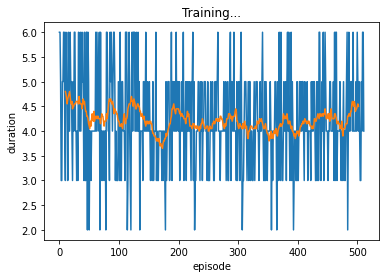

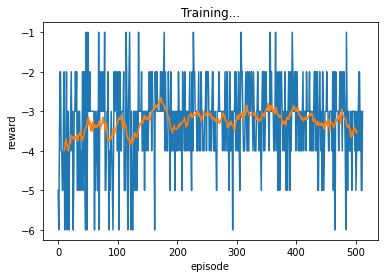

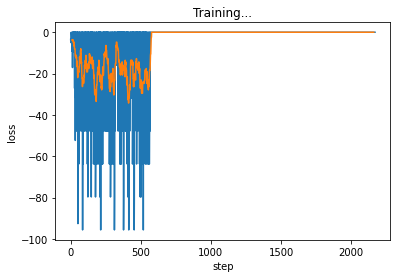

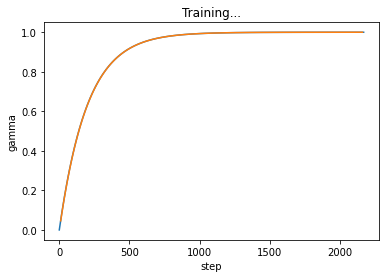

In [15]:
plot_all(*run_experiment(
    model=ModelConfig(name='nn'),
    num_episodes=512,
    training=TrainConfig(optimizer='rmsprop', lr=0.01, batch_size=-1, train_interval=128, clear_memory=True),
    seed=1,
    run_test=True
    ))

=========================episode 0 nanny======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 0 nanny-------
reward 0 done True action 0
episode 0 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.014888060396937353  steps 4  memory 0
=========================episode 1 beefy======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 edify-------
reward -1 done False action 0
------guess 2 0 beefy-------
reward 0 done True action 0
episode 1 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.029554466451491845  steps 7  memory 4
=========================episode 2 mossy======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 mossy-------
reward 0 done True action 0
episode 2 finished.  reward

------guess 1 1 loric-------
reward -1 done False action 1
------guess 2 1 bundh-------
reward -1 done False action 1
------guess 3 0 lousy-------
reward 0 done True action 0
episode 19 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.35917572396768127  steps 90  memory 86
=========================episode 20 slang======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 0 slang-------
reward 0 done True action 0
episode 20 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.3718648948103592  steps 94  memory 90
=========================episode 21 alter======================
------guess 0 0 venom-------
reward -1 done False action 0
------guess 1 0 baker-------
reward -1 done False action 0
------guess 2 1 clits-------
reward -1 done False action 1
------guess 3 0 alter-------
reward 0 done True action 0
episode 21 finished.  rewa

------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 howdy-------
reward -1 done False action 0
------guess 3 0 foggy-------
reward 0 done True action 0
episode 40 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.5913924013591516  steps 180  memory 176
=========================episode 41 dandy======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 banal-------
reward -1 done False action 0
------guess 2 0 fanny-------
reward -1 done False action 0
------guess 3 1 scudi-------
reward -1 done False action 1
------guess 4 1 whump-------
reward -1 done False action 1
------guess 5 0 dandy-------
reward 0 done True action 0
episode 41 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.6034685809250071  steps 186  memory 180
=========================episode 42 pluck======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin

------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 shown-------
reward -1 done False action 0
------guess 2 0 snowy-------
reward 0 done True action 0
episode 61 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.7288274649544001  steps 262  memory 259
=========================episode 62 tenor======================
------guess 0 0 molar-------
reward -1 done False action 0
------guess 1 1 senti-------
reward -1 done False action 1
------guess 2 1 duchy-------
reward -1 done False action 1
------guess 3 0 tenor-------
reward 0 done True action 0
episode 62 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.7341970409110734  steps 266  memory 262
=========================episode 63 cinch======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 pinch-------
reward -1 done False action 0
------guess 3 0 finch-------
reward -1 done False action 0
------guess 4 1 mudge

------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 gauze-------
reward -1 done False action 0
------guess 3 0 gaffe-------
reward 0 done True action 0
episode 81 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.8296670111745905  steps 355  memory 351
=========================episode 82 aider======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 safer-------
reward -1 done False action 0
------guess 2 1 linch-------
reward -1 done False action 1
------guess 3 0 aider-------
reward 0 done True action 0
episode 82 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.8330398303329594  steps 359  memory 355
=========================episode 83 right======================
------guess 0 0 spelt-------
reward -1 done False action 0
------guess 1 0 tarot-------
reward -1 done False action 0
------guess 2 0 right-------
reward 0 done True action 0
episode 83 finished.  r

------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 level-------
reward 0 done True action 0
episode 101 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.8886414384950874  steps 440  memory 437
=========================episode 102 bobby======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 folio-------
reward -1 done False action 0
------guess 2 0 soggy-------
reward -1 done False action 0
------guess 3 0 hobby-------
reward -1 done False action 0
------guess 4 1 dunce-------
reward -1 done False action 1
------guess 5 0 bobby-------
reward 0 done True action 0
episode 102 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.8919325813651707  steps 446  memory 440
=========================episode 103 jumbo======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 lingo-------
reward -1 done False action 0
------guess 2 1 c

------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 third-------
reward -1 done False action 0
------guess 3 1 crump-------
reward -1 done False action 1
------guess 4 0 drift-------
reward 0 done True action 0
episode 120 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9282810305914092  steps 528  memory 523
=========================episode 121 bible======================
------guess 0 0 bacon-------
reward -1 done False action 0
------guess 1 0 bushy-------
reward -1 done False action 0
------guess 2 1 litre-------
reward -1 done False action 1
------guess 3 1 damps-------
reward -1 done False action 1
------guess 4 0 bible-------
reward 0 done True action 0
episode 121 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9300517782553447  steps 533  memory 528
=========================episode 122 proud======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 l

------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 moral-------
reward -1 done False action 0
------guess 3 0 flora-------
reward 0 done True action 0
episode 139 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9516843618739322  steps 607  memory 46
=========================episode 140 trunk======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 thrum-------
reward -1 done False action 0
------guess 2 0 trust-------
reward -1 done False action 0
------guess 3 0 truly-------
reward -1 done False action 0
------guess 4 0 truck-------
reward -1 done False action 0
------guess 5 1 pined-------
reward -1 done True action 1
episode 140 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.9531123047800115  steps 613  memory 50
=========================episode 141 relay======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 re

------guess 1 1 solei-------
reward -1 done False action 1
------guess 2 0 stain-------
reward 0 done True action 0
episode 160 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.968095237957392  steps 690  memory 130
=========================episode 161 drive======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 bribe-------
reward -1 done False action 0
------guess 3 0 crime-------
reward -1 done False action 0
------guess 4 0 gripe-------
reward -1 done False action 0
------guess 5 1 khuds-------
reward -1 done True action 1
episode 161 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.9690381661768231  steps 696  memory 133
=========================episode 162 drain======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 brain-------
reward -1 done False action 0
------guess 3 0 d

------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 gummy-------
reward -1 done False action 0
------guess 2 0 gypsy-------
reward 0 done True action 0
episode 181 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9795546539620623  steps 779  memory 219
=========================episode 182 shied======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 shied-------
reward 0 done True action 0
episode 182 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9798590455087114  steps 782  memory 222
=========================episode 183 antic======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 antic-------
reward 0 done True action 0
episode 183 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9801589052556298  steps 785  memory 225
=========================episode 

------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 tuber-------
reward -1 done False action 0
------guess 2 0 retry-------
reward -1 done False action 0
------guess 3 1 linds-------
reward -1 done False action 1
------guess 4 0 inert-------
reward 0 done True action 0
episode 203 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9864314409877991  steps 861  memory 299
=========================episode 204 naive======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 naive-------
reward 0 done True action 0
episode 204 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9866334505138721  steps 864  memory 304
=========================episode 205 waver======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 early-------
reward -1 done False action 0
------guess 2 0 wager-------
reward -1 done False action 0
------guess 3 0 w

------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 cargo-------
reward -1 done False action 0
------guess 2 0 moral-------
reward -1 done False action 0
------guess 3 0 foray-------
reward -1 done False action 0
------guess 4 0 borax-------
reward 0 done True action 0
episode 224 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9912175511682391  steps 948  memory 386
=========================episode 225 rainy======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 rainy-------
reward 0 done True action 0
episode 225 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9913483047968794  steps 951  memory 391
=========================episode 226 midst======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 shift-------
reward -1 done False action 0
------guess 3 0 m

------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 fight-------
reward -1 done False action 0
------guess 2 0 uncut-------
reward 0 done True action 0
episode 245 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.994053782643528  steps 1026  memory 466
=========================episode 246 lance======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 alive-------
reward -1 done False action 0
------guess 2 0 fable-------
reward -1 done False action 0
------guess 3 0 lapse-------
reward -1 done False action 0
------guess 4 0 lance-------
reward 0 done True action 0
episode 246 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9942005952731578  steps 1031  memory 469
=========================episode 247 hinge======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 slime-------
reward -1 done False action 0
------guess 2 0 wince-------
reward -1 done False action 0
------guess 3 0 

------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 posse-------
reward -1 done False action 0
------guess 2 0 bloke-------
reward -1 done False action 0
------guess 3 0 evoke-------
reward 0 done True action 0
episode 265 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9960734731616944  steps 1109  memory 40
=========================episode 266 curry======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 dryly-------
reward -1 done False action 0
------guess 2 0 hurry-------
reward -1 done False action 0
------guess 3 0 curry-------
reward 0 done True action 0
episode 266 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9961512236023895  steps 1113  memory 44
=========================episode 267 equal======================
------guess 0 0 anode-------
reward -1 done False action 0
------guess 1 0 valet-------
reward -1 done False action 0
------guess 2 0 clear-------
reward -1 done False action 0
------guess 3 0 e

------guess 1 0 conch-------
reward -1 done False action 0
------guess 2 0 spoon-------
reward -1 done False action 0
------guess 3 0 snoop-------
reward 0 done True action 0
episode 286 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9973679703489868  steps 1189  memory 120
=========================episode 287 crest======================
------guess 0 0 pithy-------
reward -1 done False action 0
------guess 1 0 blunt-------
reward -1 done False action 0
------guess 2 0 sweet-------
reward -1 done False action 0
------guess 3 0 crest-------
reward 0 done True action 0
episode 287 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9974200880279728  steps 1193  memory 124
=========================episode 288 dutch======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 nutty-------
reward -1 done False action 0
------guess 2 0 dutch-------
reward 0 done True action 0
episode 288 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.997458497913

------guess 1 1 roate-------
reward -1 done False action 1
------guess 2 0 meter-------
reward -1 done False action 0
------guess 3 0 ether-------
reward 0 done True action 0
episode 307 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9982532528637389  steps 1271  memory 202
=========================episode 308 stork======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 throw-------
reward -1 done False action 0
------guess 2 0 droit-------
reward -1 done False action 0
------guess 3 0 stork-------
reward 0 done True action 0
episode 308 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9982878407744344  steps 1275  memory 206
=========================episode 309 widen======================
------guess 0 0 lathe-------
reward -1 done False action 0
------guess 1 0 preen-------
reward -1 done False action 0
------guess 2 0 given-------
reward -1 done False action 0
------guess 3 0 widen-------
reward 0 done True action 0
episode 309 finis

------guess 3 0 rural-------
reward 0 done True action 0
episode 329 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9988523053490985  steps 1355  memory 286
=========================episode 330 quiet======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 edict-------
reward -1 done False action 0
------guess 2 0 quiet-------
reward 0 done True action 0
episode 330 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9988693922963784  steps 1358  memory 290
=========================episode 331 lyric======================
------guess 0 0 ralph-------
reward -1 done False action 0
------guess 1 0 elder-------
reward -1 done False action 0
------guess 2 0 wryly-------
reward -1 done False action 0
------guess 3 0 lyric-------
reward 0 done True action 0
episode 331 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9988917798288798  steps 1362  memory 293
=========================episode 332 latte======================
------guess 0 1 orate---

------guess 2 0 teeth-------
reward -1 done False action 0
------guess 3 0 depth-------
reward 0 done True action 0
episode 350 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9992345142819025  steps 1436  memory 367
=========================episode 351 cocoa======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 loyal-------
reward -1 done False action 0
------guess 2 0 cocoa-------
reward 0 done True action 0
episode 351 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9992459108795064  steps 1439  memory 371
=========================episode 352 drier======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 river-------
reward -1 done False action 0
------guess 2 0 crier-------
reward -1 done False action 0
------guess 3 0 drier-------
reward 0 done True action 0
episode 352 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9992608428445372  steps 1443  memory 374
=========================episo

------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 begat-------
reward -1 done False action 0
------guess 2 0 petal-------
reward 0 done True action 0
episode 372 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9994970400433102  steps 1520  memory 452
=========================episode 373 mafia======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 valid-------
reward -1 done False action 0
------guess 2 0 mafia-------
reward 0 done True action 0
episode 373 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9995045281415226  steps 1523  memory 455
=========================episode 374 poise======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 movie-------
reward -1 done False action 0
------guess 2 0 poise-------
reward 0 done True action 0
episode 374 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9995119047564766  steps 1526  memory 458
=========================episo

------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 flume-------
reward -1 done False action 0
------guess 3 0 fluke-------
reward 0 done True action 0
episode 394 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9996711799771859  steps 1605  memory 37
=========================episode 395 width======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 twixt-------
reward -1 done False action 0
------guess 3 0 width-------
reward 0 done True action 0
episode 395 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.999677691049881  steps 1609  memory 41
=========================episode 396 marsh======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 scrap-------
reward -1 done False action 0
------guess 3 0 marsh-------
reward 0 done True action 0
episode 396 finished

------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 rupee-------
reward -1 done False action 0
------guess 3 0 freed-------
reward -1 done False action 0
------guess 4 0 creek-------
reward 0 done True action 0
episode 415 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9997892841469352  steps 1694  memory 125
=========================episode 416 wrung======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 virus-------
reward -1 done False action 0
------guess 2 0 crump-------
reward -1 done False action 0
------guess 3 0 drunk-------
reward -1 done False action 0
------guess 4 0 wrung-------
reward 0 done True action 0
episode 416 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9997944867398845  steps 1699  memory 130
=========================episode 417 snort======================
------guess 0 0 inane-------
reward -1 done False action 0
------guess 1 1

------guess 1 1 rotal-------
reward -1 done False action 1
------guess 2 0 slice-------
reward -1 done False action 0
------guess 3 0 slime-------
reward 0 done True action 0
episode 436 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.999858044935837  steps 1773  memory 205
=========================episode 437 mambo======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 macho-------
reward -1 done False action 0
------guess 3 0 mambo-------
reward 0 done True action 0
episode 437 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9998608558344383  steps 1777  memory 209
=========================episode 438 party======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 party-------
reward 0 done True action 0
episode 438 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9998629274211

------guess 3 0 crave-------
reward -1 done False action 0
------guess 4 0 aware-------
reward 0 done True action 0
episode 457 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9999048446748553  steps 1853  memory 284
=========================episode 458 motor======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 motor-------
reward 0 done True action 0
episode 458 finished.  reward -1  eps [0.9, 0.05, 200]  gamma 0.9999057914861601  steps 1855  memory 289
=========================episode 459 river======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 cider-------
reward -1 done False action 0
------guess 3 0 fiber-------
reward -1 done False action 0
------guess 4 0 viper-------
reward -1 done False action 0
------guess 5 0 giver-------
reward -1 done True action 0
episode 459 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.99990857576

------guess 2 0 going-------
reward -1 done False action 0
------guess 3 0 mogul-------
reward -1 done False action 0
------guess 4 0 dough-------
reward 0 done True action 0
episode 478 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.999938100595582  steps 1939  memory 370
=========================episode 479 flint======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 flint-------
reward 0 done True action 0
episode 479 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9999390221576535  steps 1942  memory 375
=========================episode 480 toxin======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 toxin-------
reward 0 done True action 0
episode 480 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9999399299994532  steps 1945  memory 378
=========================episod

------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 began-------
reward -1 done False action 0
------guess 3 0 haven-------
reward -1 done False action 0
------guess 4 0 waxen-------
reward 0 done True action 0
episode 499 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9999597338744681  steps 2025  memory 456
=========================episode 500 unset======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 setup-------
reward -1 done False action 0
------guess 2 0 unset-------
reward 0 done True action 0
episode 500 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.999960333358977  steps 2028  memory 461
=========================episode 501 swept======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 duvet-------
reward -1 done False action 0
------guess 2 0 spelt-------
reward -1 done False action 0
------guess 3 0 

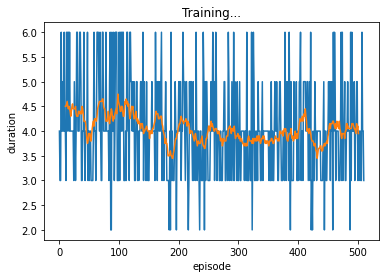

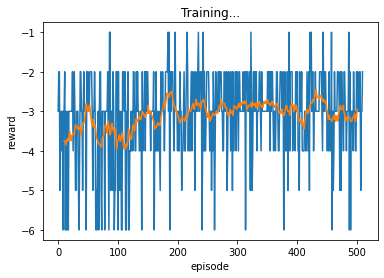

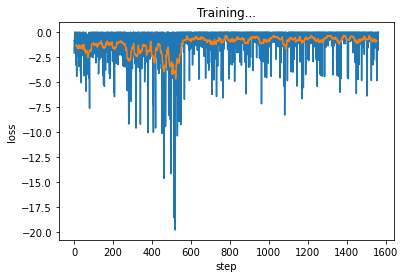

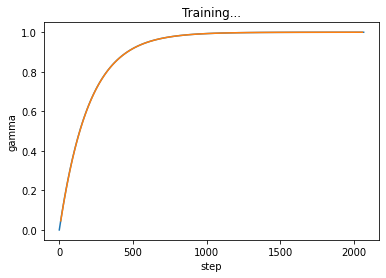

In [22]:
plot_all(*run_experiment(
    model=ModelConfig(name='hybrid'),
    num_episodes=256,
    training=TrainConfig(optimizer='sgd', lr=0.01, batch_size=-1, train_interval=128, clear_memory=True),
    seed=1,
    run_test=True
    ))

=========================episode 0 nanny======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 0 nanny-------
reward 0 done True action 0
episode 0 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.014888060396937353  steps 4  memory 0
=========================episode 1 beefy======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 edify-------
reward -1 done False action 0
------guess 2 0 beefy-------
reward 0 done True action 0
episode 1 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.029554466451491845  steps 7  memory 4
=========================episode 2 mossy======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 mossy-------
reward 0 done True action 0
episode 2 finished.  reward

------guess 1 1 loric-------
reward -1 done False action 1
------guess 2 1 bundh-------
reward -1 done False action 1
------guess 3 0 lousy-------
reward 0 done True action 0
episode 19 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.35917572396768127  steps 90  memory 86
=========================episode 20 slang======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 0 slang-------
reward 0 done True action 0
episode 20 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.3718648948103592  steps 94  memory 90
=========================episode 21 alter======================
------guess 0 0 venom-------
reward -1 done False action 0
------guess 1 0 baker-------
reward -1 done False action 0
------guess 2 1 clits-------
reward -1 done False action 1
------guess 3 0 alter-------
reward 0 done True action 0
episode 21 finished.  rewa

------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 howdy-------
reward -1 done False action 0
------guess 3 0 foggy-------
reward 0 done True action 0
episode 40 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.5913924013591516  steps 180  memory 176
=========================episode 41 dandy======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 banal-------
reward -1 done False action 0
------guess 2 0 fanny-------
reward -1 done False action 0
------guess 3 1 scudi-------
reward -1 done False action 1
------guess 4 1 whump-------
reward -1 done False action 1
------guess 5 0 dandy-------
reward 0 done True action 0
episode 41 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.6034685809250071  steps 186  memory 180
=========================episode 42 pluck======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin

------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 shown-------
reward -1 done False action 0
------guess 2 0 snowy-------
reward 0 done True action 0
episode 61 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.7288274649544001  steps 262  memory 259
=========================episode 62 tenor======================
------guess 0 0 molar-------
reward -1 done False action 0
------guess 1 1 senti-------
reward -1 done False action 1
------guess 2 1 duchy-------
reward -1 done False action 1
------guess 3 0 tenor-------
reward 0 done True action 0
episode 62 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.7341970409110734  steps 266  memory 262
=========================episode 63 cinch======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 pinch-------
reward -1 done False action 0
------guess 3 0 finch-------
reward -1 done False action 0
------guess 4 1 mudge

------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 gauze-------
reward -1 done False action 0
------guess 3 0 gaffe-------
reward 0 done True action 0
episode 81 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.8296670111745905  steps 355  memory 351
=========================episode 82 aider======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 safer-------
reward -1 done False action 0
------guess 2 1 linch-------
reward -1 done False action 1
------guess 3 0 aider-------
reward 0 done True action 0
episode 82 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.8330398303329594  steps 359  memory 355
=========================episode 83 right======================
------guess 0 0 spelt-------
reward -1 done False action 0
------guess 1 0 tarot-------
reward -1 done False action 0
------guess 2 0 right-------
reward 0 done True action 0
episode 83 finished.  r

------guess 2 0 level-------
reward 0 done True action 0
episode 101 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.8886414384950874  steps 440  memory 437
=========================episode 102 bobby======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 folio-------
reward -1 done False action 0
------guess 2 0 soggy-------
reward -1 done False action 0
------guess 3 0 hobby-------
reward -1 done False action 0
------guess 4 1 dunce-------
reward -1 done False action 1
------guess 5 0 bobby-------
reward 0 done True action 0
episode 102 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.8919325813651707  steps 446  memory 440
=========================episode 103 jumbo======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 lingo-------
reward -1 done False action 0
------guess 2 1 cushy-------
reward -1 done False action 1
------guess 3 0 jumbo-------
reward 0 done True action 0
episode 103 finishe

------guess 3 1 crump-------
reward -1 done False action 1
------guess 4 0 drift-------
reward 0 done True action 0
episode 120 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9282810305914092  steps 528  memory 523
=========================episode 121 bible======================
------guess 0 0 bacon-------
reward -1 done False action 0
------guess 1 0 bushy-------
reward -1 done False action 0
------guess 2 1 litre-------
reward -1 done False action 1
------guess 3 1 damps-------
reward -1 done False action 1
------guess 4 0 bible-------
reward 0 done True action 0
episode 121 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9300517782553447  steps 533  memory 528
=========================episode 122 proud======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 droop-------
reward -1 done False action 0
------guess 3 0 proud-------
reward 0 done True action 0
episode 122 finishe

------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 admin-------
reward -1 done False action 0
------guess 2 0 smash-------
reward -1 done False action 0
------guess 3 0 psalm-------
reward 0 done True action 0
episode 141 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.952641075608859  steps 611  memory 50
=========================episode 142 erect======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 erupt-------
reward -1 done False action 0
------guess 2 0 erect-------
reward 0 done True action 0
episode 142 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9533461581355284  steps 614  memory 54
=========================episode 143 clerk======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 infer-------
reward -1 done False action 0
------guess 2 0 clerk-------
reward 0 done True action 0
episode 143 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9540407433509558 

------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 exalt-------
reward -1 done False action 0
------guess 2 0 heath-------
reward -1 done False action 0
------guess 3 0 tease-------
reward 0 done True action 0
episode 163 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9690381661768231  steps 696  memory 135
=========================episode 164 suing======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 pinky-------
reward -1 done False action 0
------guess 2 0 undid-------
reward -1 done False action 0
------guess 3 0 suing-------
reward 0 done True action 0
episode 164 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9696512515633778  steps 700  memory 139
=========================episode 165 owner======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 credo-------
reward -1 done False action 0
------guess 2 0 owner-------
reward 0 done True action 0
episode 165 finishe

------guess 1 0 ensue-------
reward -1 done False action 0
------guess 2 0 pesky-------
reward 0 done True action 0
episode 184 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9792456621263003  steps 776  memory 216
=========================episode 185 pique======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 wedge-------
reward -1 done False action 0
------guess 2 0 slime-------
reward -1 done False action 0
------guess 3 0 niche-------
reward -1 done False action 0
------guess 4 0 pique-------
reward 0 done True action 0
episode 185 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9797580885541957  steps 781  memory 219
=========================episode 186 black======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 black-------
reward 0 done True action 0
episode 186 finished.  reward -1  eps [0.9, 0.05, 200]  gamma 0.979959498938316  steps 783  memory 224
=========================episode 1

------guess 1 0 strap-------
reward -1 done False action 0
------guess 2 0 altar-------
reward 0 done True action 0
episode 206 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9867001164575563  steps 865  memory 305
=========================episode 207 colon======================
------guess 0 0 drape-------
reward -1 done False action 0
------guess 1 0 mummy-------
reward -1 done False action 0
------guess 2 0 shift-------
reward -1 done False action 0
------guess 3 0 blown-------
reward -1 done False action 0
------guess 4 0 colon-------
reward 0 done True action 0
episode 207 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9870284917522321  steps 870  memory 308
=========================episode 208 payee======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 alike-------
reward -1 done False action 0
------guess 2 0 masse-------
reward -1 done False action 0
------guess 3 0 vague-------
reward -1 done False action 0
------guess 4 0 p

------guess 4 0 prowl-------
reward 0 done True action 0
episode 226 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9913483047968794  steps 951  memory 389
=========================episode 227 jumbo======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 floss-------
reward -1 done False action 0
------guess 2 0 dingo-------
reward -1 done False action 0
------guess 3 0 jumbo-------
reward 0 done True action 0
episode 227 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9915196198400468  steps 955  memory 394
=========================episode 228 biddy======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 spill-------
reward -1 done False action 0
------guess 2 0 ninny-------
reward -1 done False action 0
------guess 3 0 fizzy-------
reward -1 done False action 0
------guess 4 0 biddy-------
reward 0 done True action 0
episode 228 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.99172900117222

------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 dwelt-------
reward -1 done False action 0
------guess 2 0 knelt-------
reward -1 done False action 0
------guess 3 0 smelt-------
reward 0 done True action 0
episode 248 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9943719935855959  steps 1037  memory 476
=========================episode 249 onion======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 oddly-------
reward -1 done False action 0
------guess 2 0 owing-------
reward -1 done False action 0
------guess 3 0 onion-------
reward 0 done True action 0
episode 249 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9944834355792392  steps 1041  memory 480
=========================episode 250 dress======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 shire-------
reward -1 done False action 0
------guess 2 0 press-------
reward -1 done False action 0
------guess 3 0

------guess 3 0 smoke-------
reward -1 done False action 0
------guess 4 0 scoop-------
reward -1 done False action 0
------guess 5 0 spoon-------
reward 0 done True action 0
episode 268 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.996302136283517  steps 1121  memory 51
=========================episode 269 robin======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 lorry-------
reward -1 done False action 0
------guess 2 0 mourn-------
reward -1 done False action 0
------guess 3 0 robin-------
reward 0 done True action 0
episode 269 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9963753588910342  steps 1125  memory 57
=========================episode 270 rapid======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 rapid-------
reward 0 done True action 0
episode 270 finished.  reward -1  eps [0.9, 0.05, 200]  gamma 0.9964114246726681  steps 1127  memory 61
=========================episode 2

------guess 2 0 amend-------
reward -1 done False action 0
------guess 3 0 equal-------
reward 0 done True action 0
episode 290 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9975088230263428  steps 1200  memory 132
=========================episode 291 shout======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 idiot-------
reward -1 done False action 0
------guess 2 0 snout-------
reward -1 done False action 0
------guess 3 0 stout-------
reward -1 done False action 0
------guess 4 0 scout-------
reward -1 done False action 0
------guess 5 0 spout-------
reward -1 done True action 0
episode 291 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.9975824484326355  steps 1206  memory 136
=========================episode 292 fella======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 waxen-------
reward -1 done False action 0
------guess 2 0 speak-------
reward -1 done False action 0
------guess 3 

------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 equip-------
reward -1 done False action 0
------guess 2 0 newly-------
reward -1 done False action 0
------guess 3 0 needy-------
reward 0 done True action 0
episode 311 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9983875491655133  steps 1287  memory 219
=========================episode 312 twice======================
------guess 0 0 award-------
reward -1 done False action 0
------guess 1 0 swung-------
reward -1 done False action 0
------guess 2 0 twixt-------
reward -1 done False action 0
------guess 3 0 twice-------
reward 0 done True action 0
episode 312 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9984194778312638  steps 1291  memory 223
=========================episode 313 heron======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 decor-------
reward -1 done False action 0
------guess 2 0 heron-------
reward 0 done True action 0
episode 313 finis

------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 vogue-------
reward -1 done False action 0
------guess 2 0 chose-------
reward -1 done False action 0
------guess 3 0 choke-------
reward 0 done True action 0
episode 333 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9989718559548253  steps 1377  memory 309
=========================episode 334 repel======================
------guess 0 0 scuba-------
reward -1 done False action 0
------guess 1 0 offer-------
reward -1 done False action 0
------guess 2 0 greet-------
reward -1 done False action 0
------guess 3 0 repel-------
reward 0 done True action 0
episode 334 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9989922145709514  steps 1381  memory 313
=========================episode 335 chord======================
------guess 0 0 pupil-------
reward -1 done False action 0
------guess 1 0 shack-------
reward -1 done False action 0
------guess 2 0 chord-------
reward 0 done True action 0
episode 335 finis

------guess 2 0 under-------
reward -1 done False action 0
------guess 3 0 newer-------
reward -1 done False action 0
------guess 4 0 nicer-------
reward 0 done True action 0
episode 355 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9993210750726041  steps 1460  memory 391
=========================episode 356 nasal======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 magic-------
reward -1 done False action 0
------guess 2 0 paddy-------
reward -1 done False action 0
------guess 3 0 naval-------
reward -1 done False action 0
------guess 4 0 nasal-------
reward 0 done True action 0
episode 356 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9993378377887877  steps 1465  memory 396
=========================episode 357 abort======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 tarot-------
reward -1 done False action 0
------guess 2 0 abort-------
reward 0 done True action 0
episode 357 finis

------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 float-------
reward -1 done False action 0
------guess 2 0 aloft-------
reward 0 done True action 0
episode 375 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9995561393960971  steps 1545  memory 478
=========================episode 376 dwelt======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 debit-------
reward -1 done False action 0
------guess 2 0 dwelt-------
reward 0 done True action 0
episode 376 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9995627476195759  steps 1548  memory 481
=========================episode 377 grief======================
------guess 0 0 patch-------
reward -1 done False action 0
------guess 1 0 booby-------
reward -1 done False action 0
------guess 2 0 grind-------
reward -1 done False action 0
------guess 3 0 grime-------
reward -1 done False action 0
------guess 4 0 grief-------
reward 0 done True action 0
episode 377 finis

------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 bicep-------
reward -1 done False action 0
------guess 2 0 edify-------
reward -1 done False action 0
------guess 3 0 neigh-------
reward 0 done True action 0
episode 396 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9997054317991942  steps 1627  memory 48
=========================episode 397 shack======================
------guess 0 0 lease-------
reward -1 done False action 0
------guess 1 0 stand-------
reward -1 done False action 0
------guess 2 0 smack-------
reward -1 done False action 0
------guess 3 0 shack-------
reward 0 done True action 0
episode 397 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9997112646403717  steps 1631  memory 52
=========================episode 398 weigh======================
------guess 0 0 wrung-------
reward -1 done False action 0
------guess 1 0 weigh-------
reward 0 done True action 0
episode 398 finished.  reward -1  eps [0.9, 0.05, 200]  gamma 0.99971413760520

------guess 2 0 biome-------
reward 0 done True action 0
episode 418 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9997985561750878  steps 1703  memory 125
=========================episode 419 knife======================
------guess 0 0 unlit-------
reward -1 done False action 0
------guess 1 0 snide-------
reward -1 done False action 0
------guess 2 0 knife-------
reward 0 done True action 0
episode 419 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9998015552829197  steps 1706  memory 128
=========================episode 420 gummy======================
------guess 0 0 heave-------
reward -1 done False action 0
------guess 1 0 spout-------
reward -1 done False action 0
------guess 2 0 crumb-------
reward -1 done False action 0
------guess 3 0 dummy-------
reward -1 done False action 0
------guess 4 0 mummy-------
reward -1 done False action 0
------guess 5 0 gummy-------
reward 0 done True action 0
episode 420 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.999807420210

------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 extol-------
reward -1 done False action 0
------guess 2 0 onset-------
reward 0 done True action 0
episode 441 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9998696125297333  steps 1790  memory 212
=========================episode 442 marsh======================
------guess 0 0 skimp-------
reward -1 done False action 0
------guess 1 0 musty-------
reward -1 done False action 0
------guess 2 0 marsh-------
reward 0 done True action 0
episode 442 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9998715537462656  steps 1793  memory 215
=========================episode 443 seize======================
------guess 0 0 exult-------
reward -1 done False action 0
------guess 1 0 shake-------
reward -1 done False action 0
------guess 2 0 serve-------
reward -1 done False action 0
------guess 3 0 seize-------
reward 0 done True action 0
episode 443 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.999874097152

------guess 3 0 leech-------
reward 0 done True action 0
episode 462 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9999138999012837  steps 1873  memory 294
=========================episode 463 nicer======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 never-------
reward -1 done False action 0
------guess 2 0 nicer-------
reward 0 done True action 0
episode 463 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9999151817647536  steps 1876  memory 298
=========================episode 464 dirge======================
------guess 0 0 merge-------
reward -1 done False action 0
------guess 1 0 gorge-------
reward -1 done False action 0
------guess 2 0 large-------
reward -1 done False action 0
------guess 3 0 surge-------
reward -1 done False action 0
------guess 4 0 dirge-------
reward 0 done True action 0
episode 464 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9999172759344434  steps 1881  memory 301
=========================episo

------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 angel-------
reward -1 done False action 0
------guess 2 0 annex-------
reward 0 done True action 0
episode 482 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9999437103569626  steps 1958  memory 380
=========================episode 483 sever======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 buyer-------
reward -1 done False action 0
------guess 2 0 newer-------
reward -1 done False action 0
------guess 3 0 fever-------
reward -1 done False action 0
------guess 4 0 lever-------
reward -1 done False action 0
------guess 5 0 sever-------
reward 0 done True action 0
episode 483 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9999453739673293  steps 1964  memory 383
=========================episode 484 mammy======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 scuba-------
reward -1 done False action 0
------guess 2 0

------guess 1 0 madam-------
reward -1 done False action 0
------guess 2 0 shush-------
reward -1 done False action 0
------guess 3 0 spire-------
reward -1 done False action 0
------guess 4 0 scree-------
reward -1 done False action 0
------guess 5 0 serve-------
reward 0 done True action 0
episode 502 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9999633830752654  steps 2044  memory 463
=========================episode 503 comet======================
------guess 0 0 extol-------
reward -1 done False action 0
------guess 1 0 atone-------
reward -1 done False action 0
------guess 2 0 overt-------
reward -1 done False action 0
------guess 3 0 comet-------
reward 0 done True action 0
episode 503 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9999641081389545  steps 2048  memory 469
=========================episode 504 puffy======================
------guess 0 0 expel-------
reward -1 done False action 0
------guess 1 0 wimpy-------
reward -1 done False action 0
------guess 2 0

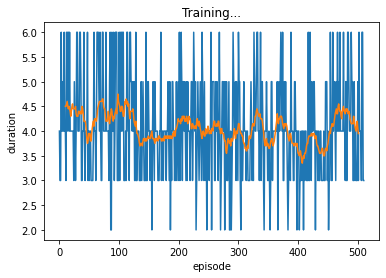

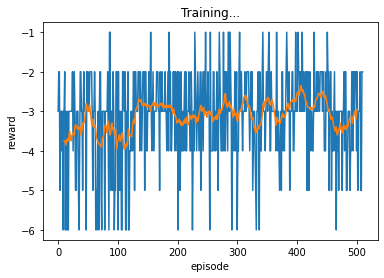

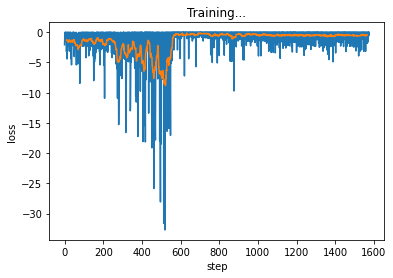

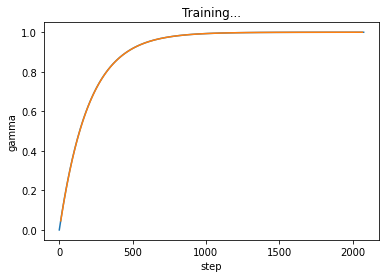

In [20]:
plot_all(*run_experiment(
    model=ModelConfig(name='hybrid'),
    num_episodes=384,
    training=TrainConfig(optimizer='adam', lr=0.01, batch_size=-1, train_interval=128, clear_memory=True),
    seed=1,
    run_test=True
    ))

=========================episode 0 nanny======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 0 nanny-------
reward 0 done True action 0
episode 0 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.014888060396937353  steps 4  memory 0
=========================episode 1 beefy======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 edify-------
reward -1 done False action 0
------guess 2 0 beefy-------
reward 0 done True action 0
episode 1 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.029554466451491845  steps 7  memory 4
=========================episode 2 mossy======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 mossy-------
reward 0 done True action 0
episode 2 finished.  reward

------guess 2 1 bundh-------
reward -1 done False action 1
------guess 3 0 lousy-------
reward 0 done True action 0
episode 19 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.35917572396768127  steps 90  memory 86
=========================episode 20 slang======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 0 slang-------
reward 0 done True action 0
episode 20 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.3718648948103592  steps 94  memory 90
=========================episode 21 alter======================
------guess 0 0 venom-------
reward -1 done False action 0
------guess 1 0 baker-------
reward -1 done False action 0
------guess 2 1 clits-------
reward -1 done False action 1
------guess 3 0 alter-------
reward 0 done True action 0
episode 21 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.38430280323571486  ste

------guess 3 0 scoff-------
reward 0 done True action 0
episode 39 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.5831379803214916  steps 176  memory 172
=========================episode 40 foggy======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 howdy-------
reward -1 done False action 0
------guess 3 0 foggy-------
reward 0 done True action 0
episode 40 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.5913924013591516  steps 180  memory 176
=========================episode 41 dandy======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 banal-------
reward -1 done False action 0
------guess 2 0 fanny-------
reward -1 done False action 0
------guess 3 1 scudi-------
reward -1 done False action 1
------guess 4 1 whump-------
reward -1 done False action 1
------guess 5 0 dandy-------
reward 0 done True action 0
episode 41 finished.  r

------guess 1 1 rotal-------
reward -1 done False action 1
------guess 2 1 synch-------
reward -1 done False action 1
------guess 3 0 stint-------
reward 0 done True action 0
episode 60 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.7247292169102477  steps 259  memory 255
=========================episode 61 snowy======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 shown-------
reward -1 done False action 0
------guess 2 0 snowy-------
reward 0 done True action 0
episode 61 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.7288274649544001  steps 262  memory 259
=========================episode 62 tenor======================
------guess 0 0 molar-------
reward -1 done False action 0
------guess 1 1 senti-------
reward -1 done False action 1
------guess 2 1 duchy-------
reward -1 done False action 1
------guess 3 0 tenor-------
reward 0 done True action 0
episode 62 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.7341970409110734  s

------guess 3 0 glove-------
reward 0 done True action 0
episode 79 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.8227155900301222  steps 347  memory 343
=========================episode 80 depth======================
------guess 0 0 index-------
reward -1 done False action 0
------guess 1 0 weedy-------
reward -1 done False action 0
------guess 2 0 dealt-------
reward -1 done False action 0
------guess 3 0 depth-------
reward 0 done True action 0
episode 80 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.8262260565495548  steps 351  memory 347
=========================episode 81 gaffe======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 gauze-------
reward -1 done False action 0
------guess 3 0 gaffe-------
reward 0 done True action 0
episode 81 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.8296670111745905  steps 355  memory 351
=========================episode 82 ai

------guess 4 1 gulch-------
reward -1 done False action 1
------guess 5 0 viper-------
reward -1 done True action 0
episode 100 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.8869584693595501  steps 437  memory 431
=========================episode 101 level======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 level-------
reward 0 done True action 0
episode 101 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.8886414384950874  steps 440  memory 437
=========================episode 102 bobby======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 folio-------
reward -1 done False action 0
------guess 2 0 soggy-------
reward -1 done False action 0
------guess 3 0 hobby-------
reward -1 done False action 0
------guess 4 1 dunce-------
reward -1 done False action 1
------guess 5 0 bobby-------
reward 0 done True action 0
episode 102 finish

------guess 5 1 fudgy-------
reward -1 done True action 1
episode 119 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.9264654562369429  steps 523  memory 517
=========================episode 120 drift======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 third-------
reward -1 done False action 0
------guess 3 1 crump-------
reward -1 done False action 1
------guess 4 0 drift-------
reward 0 done True action 0
episode 120 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9282810305914092  steps 528  memory 523
=========================episode 121 bible======================
------guess 0 0 bacon-------
reward -1 done False action 0
------guess 1 0 bushy-------
reward -1 done False action 0
------guess 2 1 litre-------
reward -1 done False action 1
------guess 3 1 damps-------
reward -1 done False action 1
------guess 4 0 bible-------
reward 0 done True action 0
episode 121 finish

------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 heavy-------
reward -1 done False action 0
------guess 2 0 email-------
reward 0 done True action 0
episode 140 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9519253371244049  steps 608  memory 48
=========================episode 141 night======================
------guess 0 0 blank-------
reward -1 done False action 0
------guess 1 0 endow-------
reward -1 done False action 0
------guess 2 0 cynic-------
reward -1 done False action 0
------guess 3 0 night-------
reward 0 done True action 0
episode 141 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9528772792296721  steps 612  memory 51
=========================episode 142 month======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 youth-------
reward -1 done False action 0
------guess 2 0 sooth-------
reward -1 done False action 0
------guess 3 0 month-------
reward 0 done True action 0
episode 142 finished.

------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 minim-------
reward -1 done False action 0
------guess 2 0 slush-------
reward -1 done False action 0
------guess 3 0 gully-------
reward -1 done False action 0
------guess 4 0 pulpy-------
reward 0 done True action 0
episode 161 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9696512515633778  steps 700  memory 138
=========================episode 162 china======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 naval-------
reward -1 done False action 0
------guess 2 0 aping-------
reward -1 done False action 0
------guess 3 0 china-------
reward 0 done True action 0
episode 162 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9702521970459025  steps 704  memory 143
=========================episode 163 poser======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 rover-------
reward -1 done False action 0
------guess 2 0 p

------guess 1 0 lefty-------
reward -1 done False action 0
------guess 2 0 testy-------
reward -1 done False action 0
------guess 3 0 deity-------
reward 0 done True action 0
episode 182 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.979959498938316  steps 783  memory 222
=========================episode 183 upset======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 tenet-------
reward -1 done False action 0
------guess 2 0 quiet-------
reward -1 done False action 0
------guess 3 0 upset-------
reward 0 done True action 0
episode 183 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9803563274469347  steps 787  memory 226
=========================episode 184 grove======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 verso-------
reward -1 done False action 0
------guess 2 0 grove-------
reward 0 done True action 0
episode 184 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.980648783630322

------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 magic-------
reward -1 done False action 0
------guess 2 0 basic-------
reward -1 done False action 0
------guess 3 0 panic-------
reward 0 done True action 0
episode 203 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9870931874195201  steps 871  memory 310
=========================episode 204 shirt======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 first-------
reward -1 done False action 0
------guess 2 0 shirt-------
reward 0 done True action 0
episode 204 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9872853448247503  steps 874  memory 314
=========================episode 205 minim======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 chill-------
reward -1 done False action 0
------guess 2 0 wispy-------
reward -1 done False action 0
------guess 3 0 minim-------
reward 0 done True action 0
episode 205 finishe

------guess 3 0 ratty-------
reward 0 done True action 0
episode 224 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9914771117575993  steps 954  memory 393
=========================episode 225 midge======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 issue-------
reward -1 done False action 0
------guess 2 0 midge-------
reward 0 done True action 0
episode 225 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9916040010325086  steps 957  memory 397
=========================episode 226 chafe======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 alive-------
reward -1 done False action 0
------guess 2 0 shape-------
reward -1 done False action 0
------guess 3 0 chafe-------
reward 0 done True action 0
episode 226 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.99177025295098  steps 961  memory 400
=========================episode 227 slump======================
------guess 0 1 orate-------


------guess 1 0 total-------
reward -1 done False action 0
------guess 2 0 bloat-------
reward -1 done False action 0
------guess 3 0 float-------
reward -1 done False action 0
------guess 4 0 gloat-------
reward 0 done True action 0
episode 245 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9945109495590727  steps 1042  memory 480
=========================episode 246 skate======================
------guess 0 0 wider-------
reward -1 done False action 0
------guess 1 0 theft-------
reward -1 done False action 0
------guess 2 0 stoke-------
reward -1 done False action 0
------guess 3 0 skate-------
reward 0 done True action 0
episode 246 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9946196400400892  steps 1046  memory 485
=========================episode 247 needy======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 debug-------
reward -1 done False action 0
------guess 2 0 seedy-------
reward -1 done False action 0
------guess 3 0

------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 brine-------
reward -1 done False action 0
------guess 2 0 pride-------
reward -1 done False action 0
------guess 3 0 prize-------
reward -1 done False action 0
------guess 4 0 prime-------
reward 0 done True action 0
episode 266 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9963571903018678  steps 1124  memory 39
=========================episode 267 raven======================
------guess 0 0 abase-------
reward -1 done False action 0
------guess 1 0 clean-------
reward -1 done False action 0
------guess 2 0 oaken-------
reward -1 done False action 0
------guess 3 0 eaten-------
reward -1 done False action 0
------guess 4 0 ramen-------
reward -1 done False action 0
------guess 5 0 raven-------
reward 0 done True action 0
episode 267 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9964648515988803  steps 1130  memory 44
=========================episode 268 girly======================
------guess 0 0 p

------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 shush-------
reward -1 done False action 0
------guess 2 0 punch-------
reward 0 done True action 0
episode 287 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9975703304049754  steps 1205  memory 122
=========================episode 288 ethos======================
------guess 0 0 spunk-------
reward -1 done False action 0
------guess 1 0 tease-------
reward -1 done False action 0
------guess 2 0 islet-------
reward -1 done False action 0
------guess 3 0 ethos-------
reward 0 done True action 0
episode 288 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9976184410863831  steps 1209  memory 125
=========================episode 289 parer======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 rarer-------
reward -1 done False action 0
------guess 2 0 parer-------
reward 0 done True action 0
episode 289 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.997653897879

------guess 2 0 major-------
reward -1 done False action 0
------guess 3 0 labor-------
reward -1 done False action 0
------guess 4 0 razor-------
reward 0 done True action 0
episode 309 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9983955912976011  steps 1288  memory 203
=========================episode 310 fishy======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 chill-------
reward -1 done False action 0
------guess 2 0 fishy-------
reward 0 done True action 0
episode 310 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9984194778312638  steps 1291  memory 208
=========================episode 311 pivot======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 botch-------
reward -1 done False action 0
------guess 2 0 stool-------
reward -1 done False action 0
------guess 3 0 ingot-------
reward -1 done False action 0
------guess 4 0 pivot-------
reward 0 done True action 0
episode 311 finis

------guess 4 0 caper-------
reward -1 done False action 0
------guess 5 0 waver-------
reward 0 done True action 0
episode 331 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9989137240585362  steps 1366  memory 280
=========================episode 332 clerk======================
------guess 0 0 logic-------
reward -1 done False action 0
------guess 1 0 cabal-------
reward -1 done False action 0
------guess 2 0 clued-------
reward -1 done False action 0
------guess 3 0 clerk-------
reward 0 done True action 0
episode 332 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.998935233763332  steps 1370  memory 286
=========================episode 333 shape======================
------guess 0 0 alley-------
reward -1 done False action 0
------guess 1 0 opera-------
reward -1 done False action 0
------guess 2 0 peace-------
reward -1 done False action 0
------guess 3 0 shape-------
reward 0 done True action 0
episode 333 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9989563175474

------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 abuse-------
reward 0 done True action 0
episode 353 finished.  reward -1  eps [0.9, 0.05, 200]  gamma 0.9992608428445372  steps 1443  memory 361
=========================episode 354 right======================
------guess 0 0 algae-------
reward -1 done False action 0
------guess 1 0 sight-------
reward -1 done False action 0
------guess 2 0 fight-------
reward -1 done False action 0
------guess 3 0 tight-------
reward -1 done False action 0
------guess 4 0 night-------
reward -1 done False action 0
------guess 5 0 might-------
reward -1 done True action 0
episode 354 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.9992826882398906  steps 1449  memory 363
=========================episode 355 ahead======================
------guess 0 0 savoy-------
reward -1 done False action 0
------guess 1 0 crawl-------
reward -1 done False action 0
------guess 2 0 aping-------
reward -1 done False action 0
------guess 3 

------guess 1 0 moody-------
reward -1 done False action 0
------guess 2 0 foggy-------
reward -1 done False action 0
------guess 3 0 lousy-------
reward -1 done False action 0
------guess 4 0 bossy-------
reward -1 done False action 0
------guess 5 0 noisy-------
reward 0 done True action 0
episode 374 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9995191715479416  steps 1529  memory 443
=========================episode 375 sting======================
------guess 0 0 fluff-------
reward -1 done False action 0
------guess 1 0 shied-------
reward -1 done False action 0
------guess 2 0 smirk-------
reward -1 done False action 0
------guess 3 0 stint-------
reward -1 done False action 0
------guess 4 0 sting-------
reward 0 done True action 0
episode 375 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9995310432447222  steps 1534  memory 449
=========================episode 376 risen======================
------guess 0 0 stage-------
reward -1 done False action 0
------guess 1 0

------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 mound-------
reward -1 done False action 0
------guess 3 0 bound-------
reward -1 done False action 0
------guess 4 0 found-------
reward 0 done True action 0
episode 394 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9996824896049968  steps 1612  memory 41
=========================episode 395 modal======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 polka-------
reward -1 done False action 0
------guess 3 0 focal-------
reward -1 done False action 0
------guess 4 0 modal-------
reward 0 done True action 0
episode 395 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9996903289645813  steps 1617  memory 46
=========================episode 396 hymen======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 l

------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 cocoa-------
reward -1 done False action 0
------guess 3 0 mocha-------
reward 0 done True action 0
episode 416 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.999791380804705  steps 1696  memory 126
=========================episode 417 wager======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 wager-------
reward 0 done True action 0
episode 417 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9997944867398845  steps 1699  memory 130
=========================episode 418 sushi======================
------guess 0 0 baker-------
reward -1 done False action 0
------guess 1 1 toils-------
reward -1 done False action 1
------guess 2 0 missy-------
reward -1 done False action 0
------guess 3 0 sushi-------
reward 0 done True action 0
episode 418 finish

------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 sprig-------
reward 0 done True action 0
episode 438 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9998587529396732  steps 1774  memory 205
=========================episode 439 penny======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 needy-------
reward -1 done False action 0
------guess 3 0 penny-------
reward 0 done True action 0
episode 439 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9998615498188592  steps 1778  memory 208
=========================episode 440 circa======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 circa-------
reward 0 done True action 0
episode 440 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.999863611073

------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 award-------
reward -1 done False action 0
------guess 3 0 dwarf-------
reward 0 done True action 0
episode 459 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9999067288765351  steps 1857  memory 287
=========================episode 460 funky======================
------guess 0 0 chasm-------
reward -1 done False action 0
------guess 1 1 oriel-------
reward -1 done False action 1
------guess 2 0 fuzzy-------
reward -1 done False action 0
------guess 3 0 funny-------
reward -1 done False action 0
------guess 4 0 funky-------
reward 0 done True action 0
episode 460 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9999090317487787  steps 1862  memory 291
=========================episode 461 unity======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0

------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 sleep-------
reward 0 done True action 0
episode 480 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9999374784962252  steps 1937  memory 368
=========================episode 481 begat======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 adept-------
reward -1 done False action 0
------guess 3 0 begat-------
reward 0 done True action 0
episode 481 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9999387165049468  steps 1941  memory 371
=========================episode 482 salon======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 salon-------
reward 0 done True action 0
episode 482 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.999939628897

------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 avail-------
reward -1 done False action 0
------guess 3 0 plaid-------
reward -1 done False action 0
------guess 4 0 claim-------
reward 0 done True action 0
episode 501 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9999597338744681  steps 2025  memory 454
=========================episode 502 heart======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 heart-------
reward 0 done True action 0
episode 502 finished.  reward -1  eps [0.9, 0.05, 200]  gamma 0.9999601345291115  steps 2027  memory 459
=========================episode 503 witch======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 thick-------
reward -1 done False action 0
------guess 3 0 pitch-------
reward -1 done False action 0
------guess 4 0

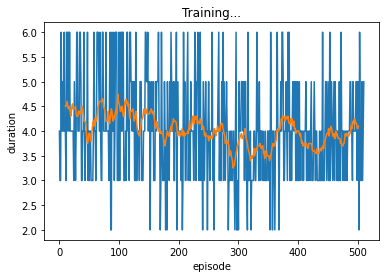

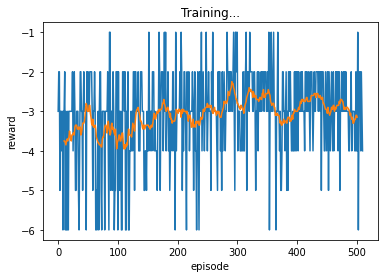

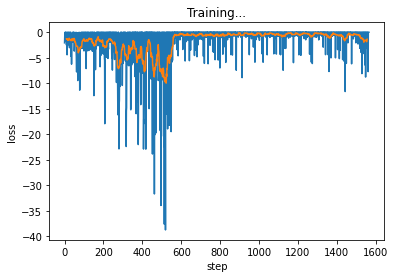

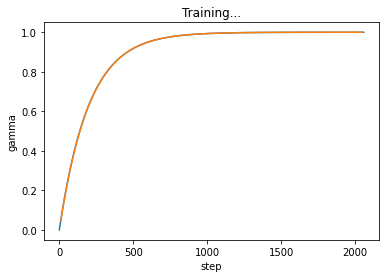

In [21]:
plot_all(*run_experiment(
    model=ModelConfig(name='hybrid'),
    num_episodes=511,
    training=TrainConfig(optimizer='rmsprop', lr=0.01, batch_size=-1, train_interval=128, clear_memory=True),
    seed=1,
    run_test=True
    ))